# **Importaciones**

In [1]:
!pip install mapclassify
!pip install geopandas
!pip install dash

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale

# Gráficos
# ==============================================================================
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
style.use('ggplot') or plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,10)
import dash
from dash import dcc
from dash import html
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Mapas
# ==============================================================================
import geopandas as gpd

# Clustering
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

# Otros
# ==============================================================================
from sklearn.linear_model import LinearRegression

from time import time
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)





# **Funciones**

In [3]:
# Función para gráfico de barras 
def plot_bar_chart(df, variables, id_var='country', palette="Set2"):
    """
    Genera un gráfico de barras con las variables especificadas.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    variables (list): Lista de columnas a utilizar como variables.
    id_var (str): Columna que identifica las categorías (por defecto 'country').
    palette (str): Paleta de colores a utilizar (por defecto 'Set2').

    Returns:
    None
    """
    sns.set(style="whitegrid")

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(20, 8))

    # Crear el gráfico de barras
    melted_df = pd.melt(df, id_vars=[id_var], value_vars=variables, var_name='Indice', value_name='Value')
    sns.barplot(x=id_var, y='Value', hue='Indice', data=melted_df, palette=palette, ci=None)

    # Añadir título y etiquetas
    plt.xlabel(id_var.capitalize())
    plt.ylabel('Value')
    plt.title('Bar Chart')

    # Rotar las etiquetas del eje x para mejor visualización
    plt.xticks(rotation=90)

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Función para gráfico de caja
def plot_box_chart(df, variables, id_var='country', palette="Set2"):
    """
    Genera un gráfico de caja con las variables especificadas.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    variables (list): Lista de columnas a utilizar como variables.
    id_var (str): Columna que identifica las categorías (por defecto 'country').
    palette (str): Paleta de colores a utilizar (por defecto 'Set2').

    Returns:
    None
    """
    sns.set(style="whitegrid")

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(12, 8))

    # Crear el gráfico de caja
    melted_df = pd.melt(df, id_vars=[id_var], value_vars=variables, var_name='Indice', value_name='Value')
    sns.boxplot(x=id_var, y='Value', hue='Indice', data=melted_df, palette=palette)

    # Añadir título y etiquetas
    plt.xlabel(id_var.capitalize())
    plt.ylabel('Value')
    plt.title('Box Plot')

    # Rotar las etiquetas del eje x para mejor visualización
    plt.xticks(rotation=90)

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Función para crear los mapas (con y sin regiones de ultramar)
def plot_regions(ax1, ax2, base_gdf, specific_gdf, overseas_gdf, column, title1, title2, cmap='YlOrRd', scheme='quantiles'):
    """
    Función para crear mapas (con y sin regiones de ultramar).

    Parámetros:
    ax1 : matplotlib.axes._subplots.AxesSubplot
        El objeto Axes para el primer mapa (regiones principales).
    ax2 : matplotlib.axes._subplots.AxesSubplot
        El objeto Axes para el segundo mapa (regiones de ultramar).
    base_gdf : geopandas.GeoDataFrame
        El GeoDataFrame base que contiene todas las regiones.
    specific_gdf : geopandas.GeoDataFrame
        El GeoDataFrame con las regiones a destacar.
    overseas_gdf : geopandas.GeoDataFrame
        El GeoDataFrame con las regiones de ultramar.
    column : str
        La columna del GeoDataFrame que se usará para la coloración.
    title1 : str
        El título del primer mapa.
    title2 : str
        El título del segundo mapa.
    cmap : str, opcional
        El mapa de colores para los gráficos (por defecto es 'YlOrRd').
    scheme : str, opcional
        El esquema de clasificación para los valores (por defecto es 'quantiles').
    """
    # Mapa para las regiones con los valores
    base_gdf.plot(ax=ax1, color='lightgrey', edgecolor='w')
    specific_gdf.plot(column=column, cmap=cmap, linewidth=1.5, edgecolor='0.8', scheme=scheme, k=5, legend=True, ax=ax1)
    ax1.set_title(title1)
    ax1.axis('off')

    # Mapa para las regiones de ultramar
    base_gdf.plot(ax=ax2, color='lightgrey', edgecolor='lightgrey')
    overseas_gdf.plot(column=column, cmap=cmap, linewidth=1.5, edgecolor='0.8', scheme=scheme, k=5, legend=True, ax=ax2)
    ax2.set_title(title2)
    ax2.axis('off')


In [4]:
"""    CLUSTERING    """
# Extraer dendograma y pintarlo
def plot_dendogram(model, **kwargs):
  '''
  Esta función extrae la información de un modelo AgglomerativeClustering
  y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
  '''

  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                        counts]).astype(float)

  # Plot
  dendrogram(linkage_matrix, **kwargs)
  plt.show()

# Evaluación del número de grupos óptimo en K-means
def scree_plot_kmeans(data,n_max):
  range_n_clusters = range(2, n_max)
  X_scaled = scale(data)
  inertias = []
  silhouette = []
  var_perc = []

  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(
                          n_clusters   = n_clusters,
                          n_init       = 20,
                          random_state = 123
                      )
      modelo_kmeans.fit(X_scaled)
      cluster_labels = modelo_kmeans.fit_predict(X_scaled)
      inertias.append(modelo_kmeans.inertia_)
      silhouette.append(silhouette_score(X_scaled, cluster_labels))
      tss = sum(pdist(X_scaled)**2)/X_scaled.shape[0] # Suma de cuadrados totales
      bss = tss - modelo_kmeans.inertia_ # Suma de cuadrados between (explicada por el cambio de grupos)
      var_perc.append(bss/tss*100) # Queremos que sea lo mas alto posible

  fig, ax = plt.subplots(1, 3, figsize=(16, 6))
  ax[0].plot(range_n_clusters, inertias, marker='o')
  ax[0].set_title("Scree plot Varianza intra")
  ax[0].set_xlabel('Número clusters')
  ax[0].set_ylabel('Intra-cluster (inertia)')

  ax[1].plot(range_n_clusters, silhouette, marker='o')
  ax[1].set_title("Scree plot silhouette")
  ax[1].set_xlabel('Número clusters')
  ax[1].set_ylabel('Media índices silhouette');

  ax[2].plot(range_n_clusters, var_perc, marker='o')
  ax[2].set_title("Scree plot % Varianza")
  ax[2].set_xlabel('Número clusters')
  ax[2].set_ylabel('% de varianza explicada')

# **Importar Indices**

In [5]:
componentes_df = pd.read_csv('02_componentes_minmax.csv')
dimensiones_df = pd.read_csv('03_dimensiones_minmax.csv')
spi_df = pd.read_csv('04_spi_minmax.csv')

In [6]:
spi_df['gdp_per_capita_2022'] = spi_df['gdp_per_capita_2022'].round(2)


* **Mergear indices**

In [7]:
componentes_df.drop(columns="gdp_per_capita_2022", inplace=True)
dimensiones_df.drop(columns="gdp_per_capita_2022", inplace=True)

In [8]:
spi_df = pd.merge(spi_df, dimensiones_df[['basic_needs', 'foundations_wellbeing', 'opportunity', 'nuts_code']], on='nuts_code')
spi_df = pd.merge(spi_df, componentes_df[['nutrition_medical_care',
                                          'water_sanitation',
                                          'safety',
                                          'basic_education',
                                          'info_comm',
                                          'health',
                                          'env_quality',
                                          'trust_gov',
                                          'freedom_choice',
                                          'inclusive_society',
                                          'adv_education',
                                          'nuts_code']], on='nuts_code')

In [9]:
spi_df.head()

nuts_code country            region    spi  gdp_per_capita_2022  \
0      AT11      AT        Burgenland  65.95                23.61   
1      AT12      AT  Niederösterreich  66.70                29.87   
2      AT13      AT              Wien  69.54                43.02   
3      AT21      AT           Kärnten  67.69                31.40   
4      AT22      AT        Steiermark  68.03                32.29   

   basic_needs  foundations_wellbeing  opportunity  nutrition_medical_care  \
0        73.24                  74.34        51.59                   72.16   
1        71.05                  76.24        53.88                   64.95   
2        70.37                  74.41        64.05                   62.89   
3        72.13                  77.58        54.49                   88.66   
4        69.22                  76.84        58.64                   79.38   

   water_sanitation  safety  basic_education  info_comm  health  env_quality  \
0             98.70   52.49            68.96      67.94   81.00        79.96   
1             99.65   52.49            68.96      69.44   83.17        84.07   
2             99.80   52.49            68.96      71.12   79.71        78.13   
3             99.94   36.80            68.96      71.52   85.88        84.71   
4             99.68   36.80            68.96      72.14   85.04        81.78   

   trust_gov  freedom_choice  inclusive_society  adv_education  
0      63.74           62.66               65.6          22.39  
1      63.28           64.09               65.6          28.09  
2      70.98           60.75               65.6          59.19  
3      59.18           67.70               70.3          27.26  
4      66.00           65.71               70.3          36.19

In [10]:
spi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nuts_code               242 non-null    object 
 1   country                 242 non-null    object 
 2   region                  242 non-null    object 
 3   spi                     242 non-null    float64
 4   gdp_per_capita_2022     242 non-null    float64
 5   basic_needs             242 non-null    float64
 6   foundations_wellbeing   242 non-null    float64
 7   opportunity             242 non-null    float64
 8   nutrition_medical_care  242 non-null    float64
 9   water_sanitation        242 non-null    float64
 10  safety                  242 non-null    float64
 11  basic_education         242 non-null    float64
 12  info_comm               242 non-null    float64
 13  health                  242 non-null    float64
 14  env_quality             242 non-null    fl

* **Geodataframe**

In [11]:
# Cargar los shapefiles de las regiones NUTS
shapefile_path = 'NUTS_RG_20M_2021_3035.shp'
gdf = gpd.read_file(shapefile_path)


In [12]:
spi_gdf=pd.merge(gdf[['NUTS_ID','geometry']], spi_df, how='right', left_on='NUTS_ID', right_on='nuts_code')
spi_gdf = spi_gdf.rename(columns={'NUTS_ID': 'nuts_code'})


# **Análisis Exploratorio de Datos**

## Estadísticos descriptivos

**[Figura 05.1]**

In [13]:
print('Figura 05.1')

spi_df.describe()

Figura 05.1


spi  gdp_per_capita_2022  basic_needs  foundations_wellbeing  \
count  242.000000           242.000000   242.000000             242.000000   
mean    60.888884            22.616157    68.592934              65.749835   
std     11.819321            15.959381    13.720825              14.929801   
min     24.720000             0.000000     9.980000              21.190000   
25%     53.785000            10.617500    61.767500              56.940000   
50%     62.655000            21.650000    71.850000              70.325000   
75%     67.960000            31.862500    78.345000              74.367500   
max     84.630000           100.000000    91.400000              92.380000   

       opportunity  nutrition_medical_care  water_sanitation      safety  \
count   242.000000              242.000000        242.000000  242.000000   
mean     50.175950               66.869463         84.304835   59.554504   
std      13.503089               14.948206         23.338232   19.285753   
min      18.720000                0.000000          0.000000    1.150000   
25%      41.190000               61.860000         79.332500   48.875000   
50%      52.060000               69.070000         95.710000   63.595000   
75%      58.337500               76.290000         99.457500   73.870000   
max      83.270000              100.000000        100.000000   91.500000   

       basic_education   info_comm     health  env_quality   trust_gov  \
count       242.000000  242.000000  242.00000   242.000000  242.000000   
mean         65.777107   59.619669   70.57814    69.976736   54.657479   
std          19.759232   18.191665   16.70554    16.511378   16.718278   
min           3.630000   10.000000   20.05000    14.140000   18.430000   
25%          60.900000   50.750000   66.03500    64.417500   41.117500   
50%          72.120000   59.940000   76.71000    74.615000   59.290000   
75%          76.770000   70.670000   81.19250    80.952500   66.230000   
max         100.000000   96.410000   93.98000    99.340000   92.110000   

       freedom_choice  inclusive_society  adv_education  
count      242.000000         242.000000     242.000000  
mean        57.266405          66.181322      29.328719  
std          9.914459          20.807258      15.982716  
min         27.800000           9.840000       3.650000  
25%         51.160000          51.242500      18.062500  
50%         57.360000          73.150000      26.580000  
75%         64.347500          80.850000      38.075000  
max         80.330000          95.020000      87.480000

## Ranking mayor y menor SPI por país y por región:

In [14]:
# Calcular el SPI medio por país
spi_mean_by_country = spi_df.groupby('country')['spi'].mean().reset_index()
spi_mean_by_country = spi_mean_by_country.sort_values(by='spi', ascending=False)

# 5 países con mayor SPI medio
top_5_countries_by_spi = spi_mean_by_country.head(5).reset_index(drop=True)

# 5 países con menor SPI medio
bottom_5_countries_by_spi = spi_mean_by_country.tail(5).reset_index(drop=True)

# Ordenar las regiones por SPI
sorted_regions_by_spi = spi_df.sort_values(by='spi', ascending=False)

# 10 regiones con mayor SPI
top_10_regions_by_spi = sorted_regions_by_spi.head(10).reset_index(drop=True)

# 10 regiones con menor SPI
bottom_10_regions_by_spi = sorted_regions_by_spi.tail(10).reset_index(drop=True)

stats_spi_pais = spi_df.groupby('country')['spi'].describe()

**[Figura 05.2]** **Ranking 5 países con mayor SPI medio**

In [15]:
print('Figura 05.2')

top_5_countries_by_spi

Figura 05.2


country        spi
0      FI  81.594000
1      SE  81.257500
2      DK  78.458000
3      NL  73.998333
4      IE  70.033333

**[Figura 05.3]** **Ranking 5 países con menor SPI medio**

In [16]:
print('Figura 05.3')
bottom_5_countries_by_spi

Figura 05.3


country        spi
0      HU  49.472500
1      SK  48.730000
2      RO  36.946250
3      HR  36.740000
4      BG  31.743333

**[Figura 05.4]** **Ranking 10 regiones con mayor SPI**

In [17]:
print('Figura 05.4')
top_10_regions_by_spi[['country', 'region', 'spi', 'gdp_per_capita_2022']]

Figura 05.4


country                 region    spi  gdp_per_capita_2022
0      SE              Stockholm  84.63                56.62
1      FI       Helsinki-Uusimaa  83.90                47.32
2      FI  Pohjois- ja Itä-Suomi  83.57                29.52
3      SE    Östra Mellansverige  83.36                33.81
4      DK            Hovedstaden  82.28                73.26
5      SE          Övre Norrland  81.79                44.01
6      FI                  Åland  81.42                36.85
7      SE     Mellersta Norrland  81.07                36.05
8      FI            Länsi-Suomi  81.07                30.86
9      DK            Midtjylland  81.05                42.84

**[Figura 05.5]** **Ranking 10 regiones con menor SPI**

In [18]:
print('Figura 05.5')
bottom_10_regions_by_spi[['country', 'region', 'spi', 'gdp_per_capita_2022']]

Figura 05.5


country              region    spi  gdp_per_capita_2022
0      FR              Guyane  34.95                 6.35
1      HR         Grad Zagreb  34.60                20.93
2      BG      Severoiztochen  33.37                 1.61
3      RO            Nord-Est  33.21                 0.54
4      BG   Yuzhen tsentralen  32.67                 0.72
5      RO    Sud-Vest Oltenia  31.98                 2.50
6      BG  Severen tsentralen  31.95                 0.36
7      RO        Sud-Muntenia  30.35                 2.50
8      BG       Severozapaden  28.84                 0.00
9      BG        Yugoiztochen  24.72                 3.04

**[Figura 05.6]** **Estadísticas descriptivas por pais**

In [19]:
stats_spi_pais.sort_values(by='mean', ascending=False).reset_index().round(2)

country  count   mean    std    min    25%    50%    75%    max
0       FI    5.0  81.59   2.36  78.01  81.07  81.42  83.57  83.90
1       SE    8.0  81.26   1.94  79.16  79.66  80.98  82.18  84.63
2       DK    5.0  78.46   3.57  73.73  75.91  79.32  81.05  82.28
3       NL   12.0  74.00   1.65  71.52  72.75  74.00  75.37  76.29
4       IE    3.0  70.03   3.35  66.89  68.27  69.65  71.60  73.56
5       EE    1.0  68.86    NaN  68.86  68.86  68.86  68.86  68.86
6       AT    9.0  67.64   1.15  65.95  66.70  67.69  68.03  69.54
7       DE   38.0  67.00   2.61  58.25  65.57  67.11  68.43  71.77
8       LU    1.0  66.99    NaN  66.99  66.99  66.99  66.99  66.99
9       LV    1.0  65.95    NaN  65.95  65.95  65.95  65.95  65.95
10      ES   19.0  65.60   3.14  57.58  64.27  65.26  67.42  70.87
11      BE   11.0  64.95   8.20  53.83  58.38  62.58  72.53  75.09
12      MT    1.0  64.81    NaN  64.81  64.81  64.81  64.81  64.81
13      SI    2.0  64.58   0.49  64.23  64.40  64.58  64.75  64.92
14      PT    7.0  63.57   6.26  55.21  59.20  63.97  68.04  71.32
15      CZ    8.0  61.24   4.13  56.46  59.18  60.78  62.60  69.42
16      FR   27.0  58.64   8.33  34.95  57.96  61.53  62.32  69.16
17      IT   21.0  57.66   5.23  44.41  55.85  58.35  62.03  64.04
18      LT    2.0  53.60  11.77  45.27  49.43  53.60  57.76  61.92
19      CY    1.0  52.82    NaN  52.82  52.82  52.82  52.82  52.82
20      EL   13.0  52.72   3.89  45.68  49.42  52.85  53.77  59.50
21      PL   17.0  51.60   2.47  47.69  50.52  52.13  52.69  56.21
22      HU    8.0  49.47   5.92  42.65  43.68  50.63  52.09  59.50
23      SK    4.0  48.73   8.80  43.73  44.34  44.64  49.03  61.92
24      RO    8.0  36.95   5.24  30.35  32.90  37.39  39.19  46.79
25      HR    4.0  36.74   1.99  34.60  35.41  36.64  37.97  39.08
26      BG    6.0  31.74   4.75  24.72  29.62  32.31  33.20  38.91

## Mapas

In [20]:
overseas = ['Guyane', 'Guadeloupe', 'Martinique', 'La Réunion', 'Mayotte', "Região Autónoma dos Açores", 'Região Autónoma da Madeira', 'Canarias']
filtered_gdf = spi_gdf[~spi_gdf['region'].isin(overseas)]
overseas_gdf = spi_gdf[spi_gdf['region'].isin(overseas)]

**[Figura 05.7]** **10 regiones con mayor score**

Figura 05.7


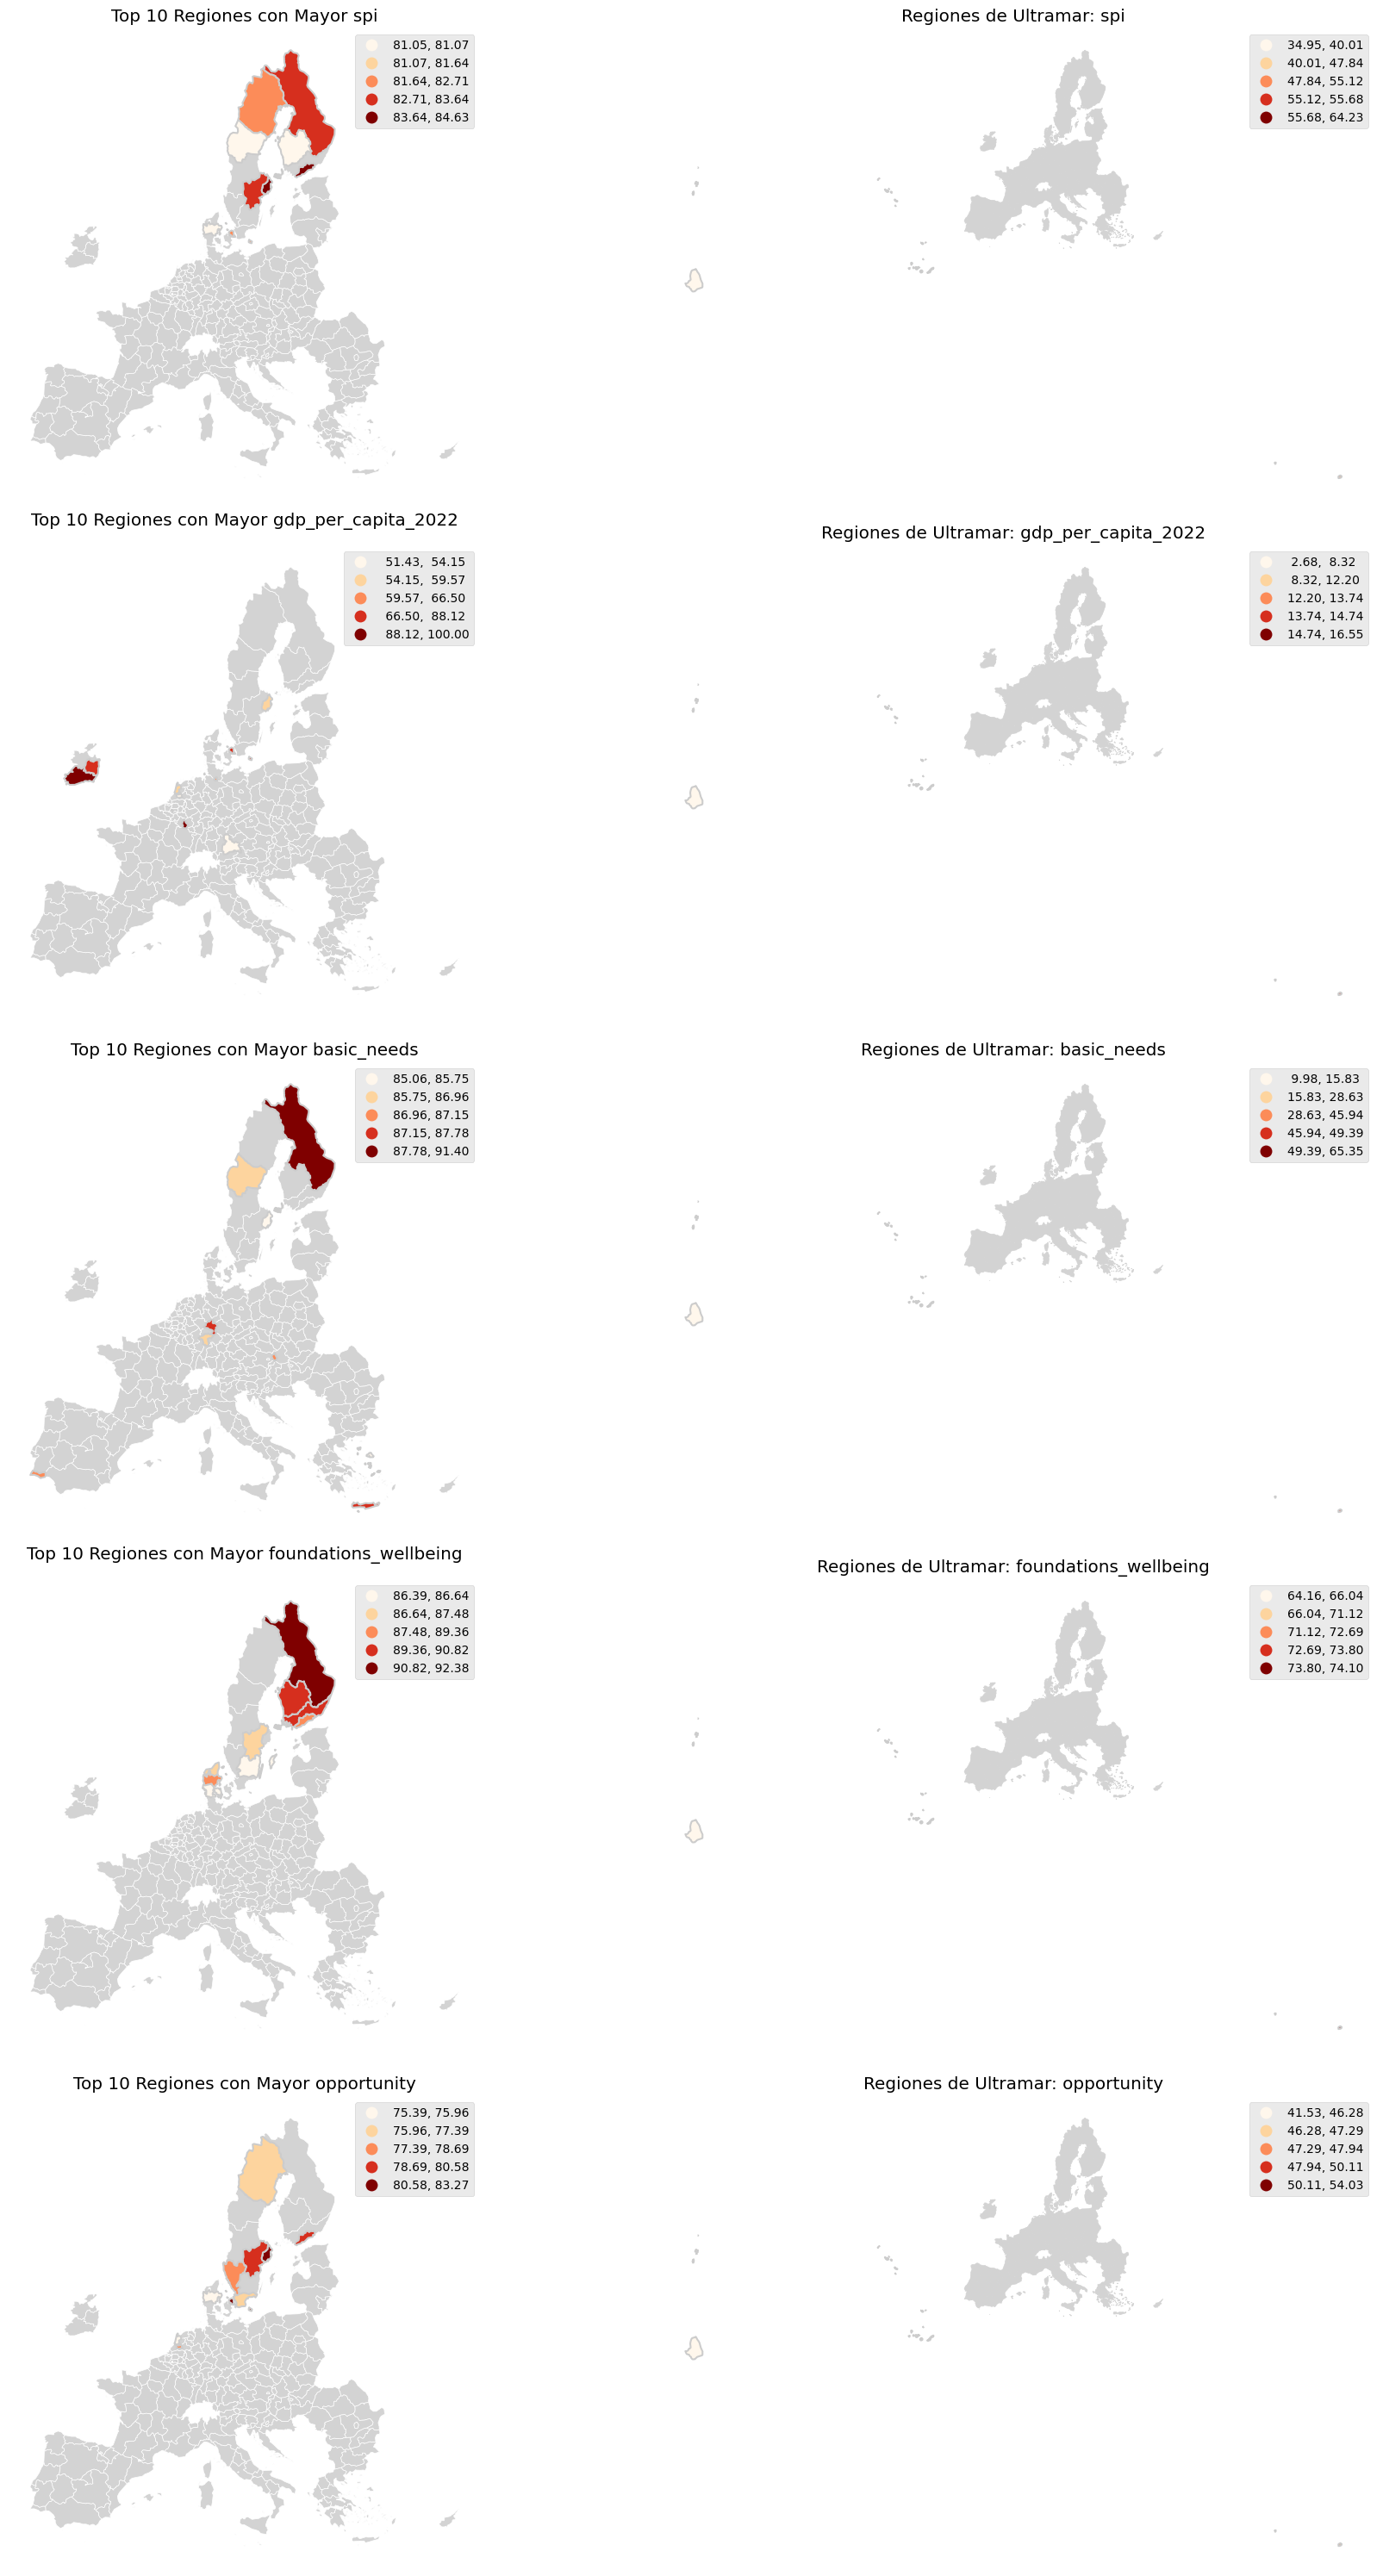

In [21]:
print('Figura 05.7')

# 10 regiones con mayores valores
columns_of_interest = ['spi', 'gdp_per_capita_2022', 'basic_needs', 'foundations_wellbeing', 'opportunity']
top_gdfs = {col: filtered_gdf.nlargest(10, col) for col in columns_of_interest}

# Crear los subplots para cada categoría
fig, axes = plt.subplots(len(columns_of_interest), 2, figsize=(20, 30))

# Mapas
for i, col in enumerate(columns_of_interest):
    cmap = 'OrRd'
    plot_regions(axes[i, 0], axes[i, 1], filtered_gdf, top_gdfs[col], overseas_gdf, col, f'Top 10 Regiones con Mayor {col}', f'Regiones de Ultramar: {col}', cmap=cmap)

plt.tight_layout()
plt.show()


**[Figura 05.8]** **10 regiones con menor score**

Figura 05.8


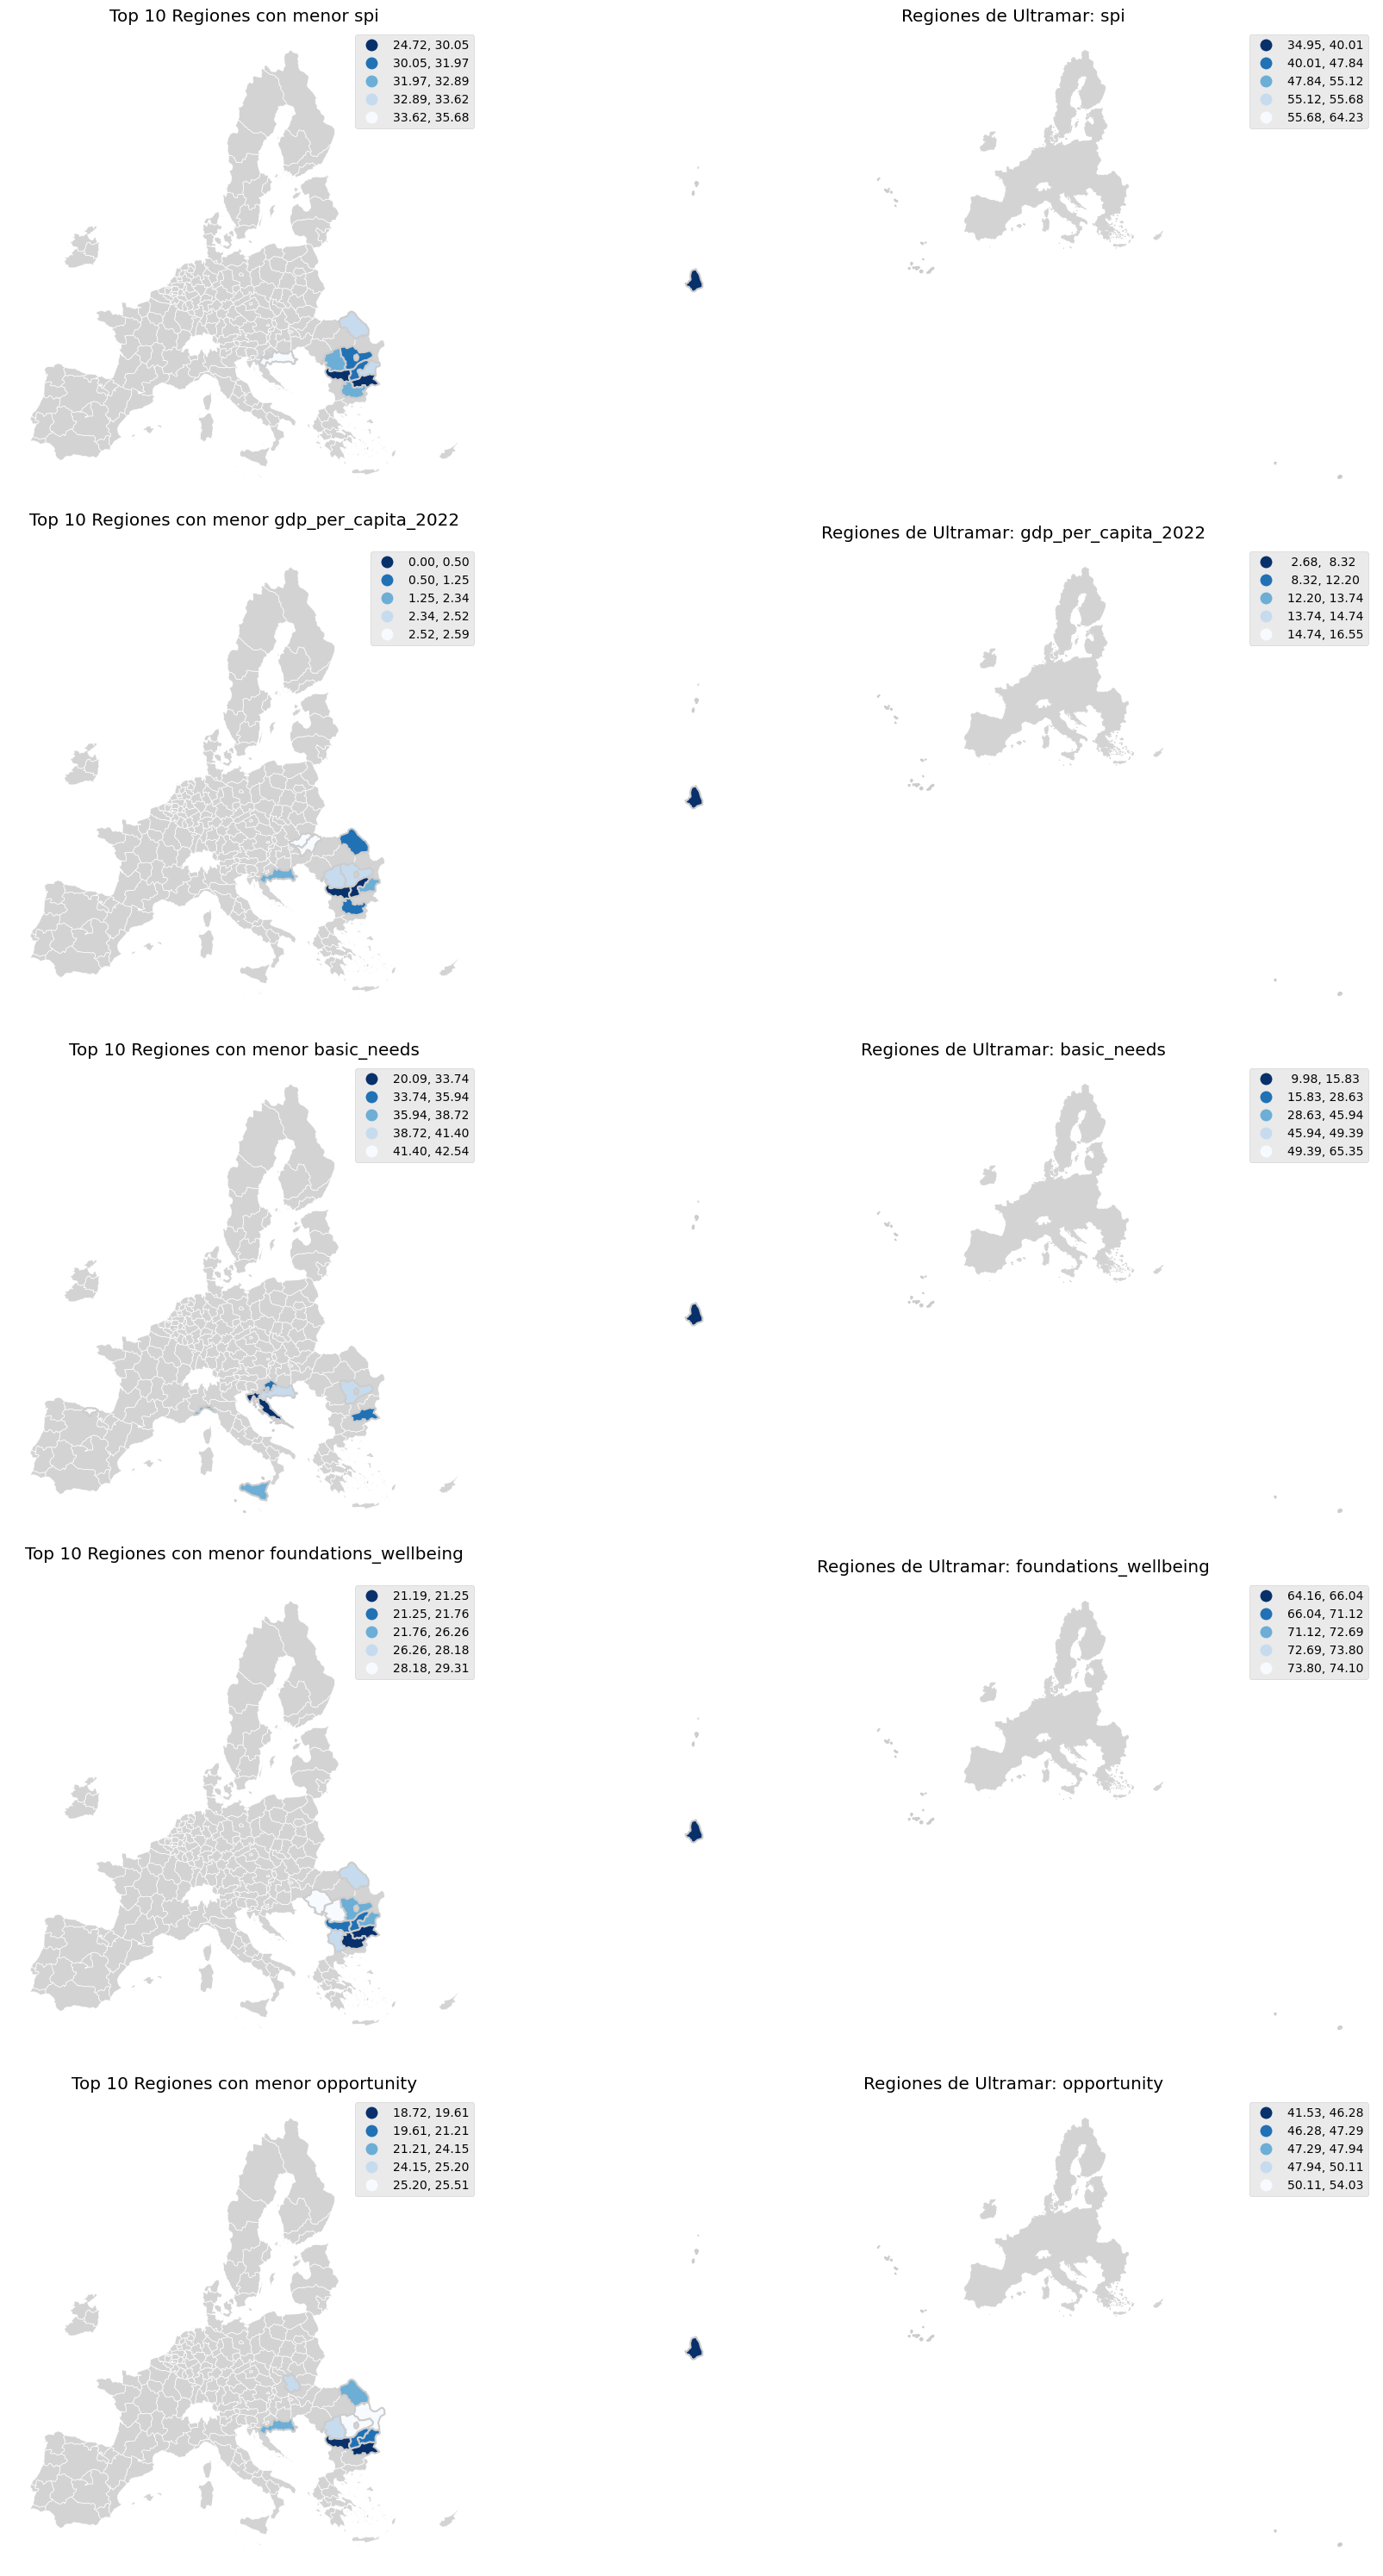

In [22]:
print('Figura 05.8')
# 10 regiones con menores valores

columns_of_interest = ['spi', 'gdp_per_capita_2022', 'basic_needs', 'foundations_wellbeing', 'opportunity']
bottom_gdfs = {col: filtered_gdf.nsmallest(10, col) for col in columns_of_interest}

# Crear los subplots para cada categoría
fig, axes = plt.subplots(len(columns_of_interest), 2, figsize=(20, 30))

# Mapas
for i, col in enumerate(columns_of_interest):
    cmap = 'Blues_r'
    plot_regions(axes[i, 0], axes[i, 1], filtered_gdf, bottom_gdfs[col], overseas_gdf, col, f'Top 10 Regiones con menor {col}', f'Regiones de Ultramar: {col}', cmap=cmap)

plt.tight_layout()
plt.show()


**[Figura 05.9]** **Todas las regiones**

Figura 05.9


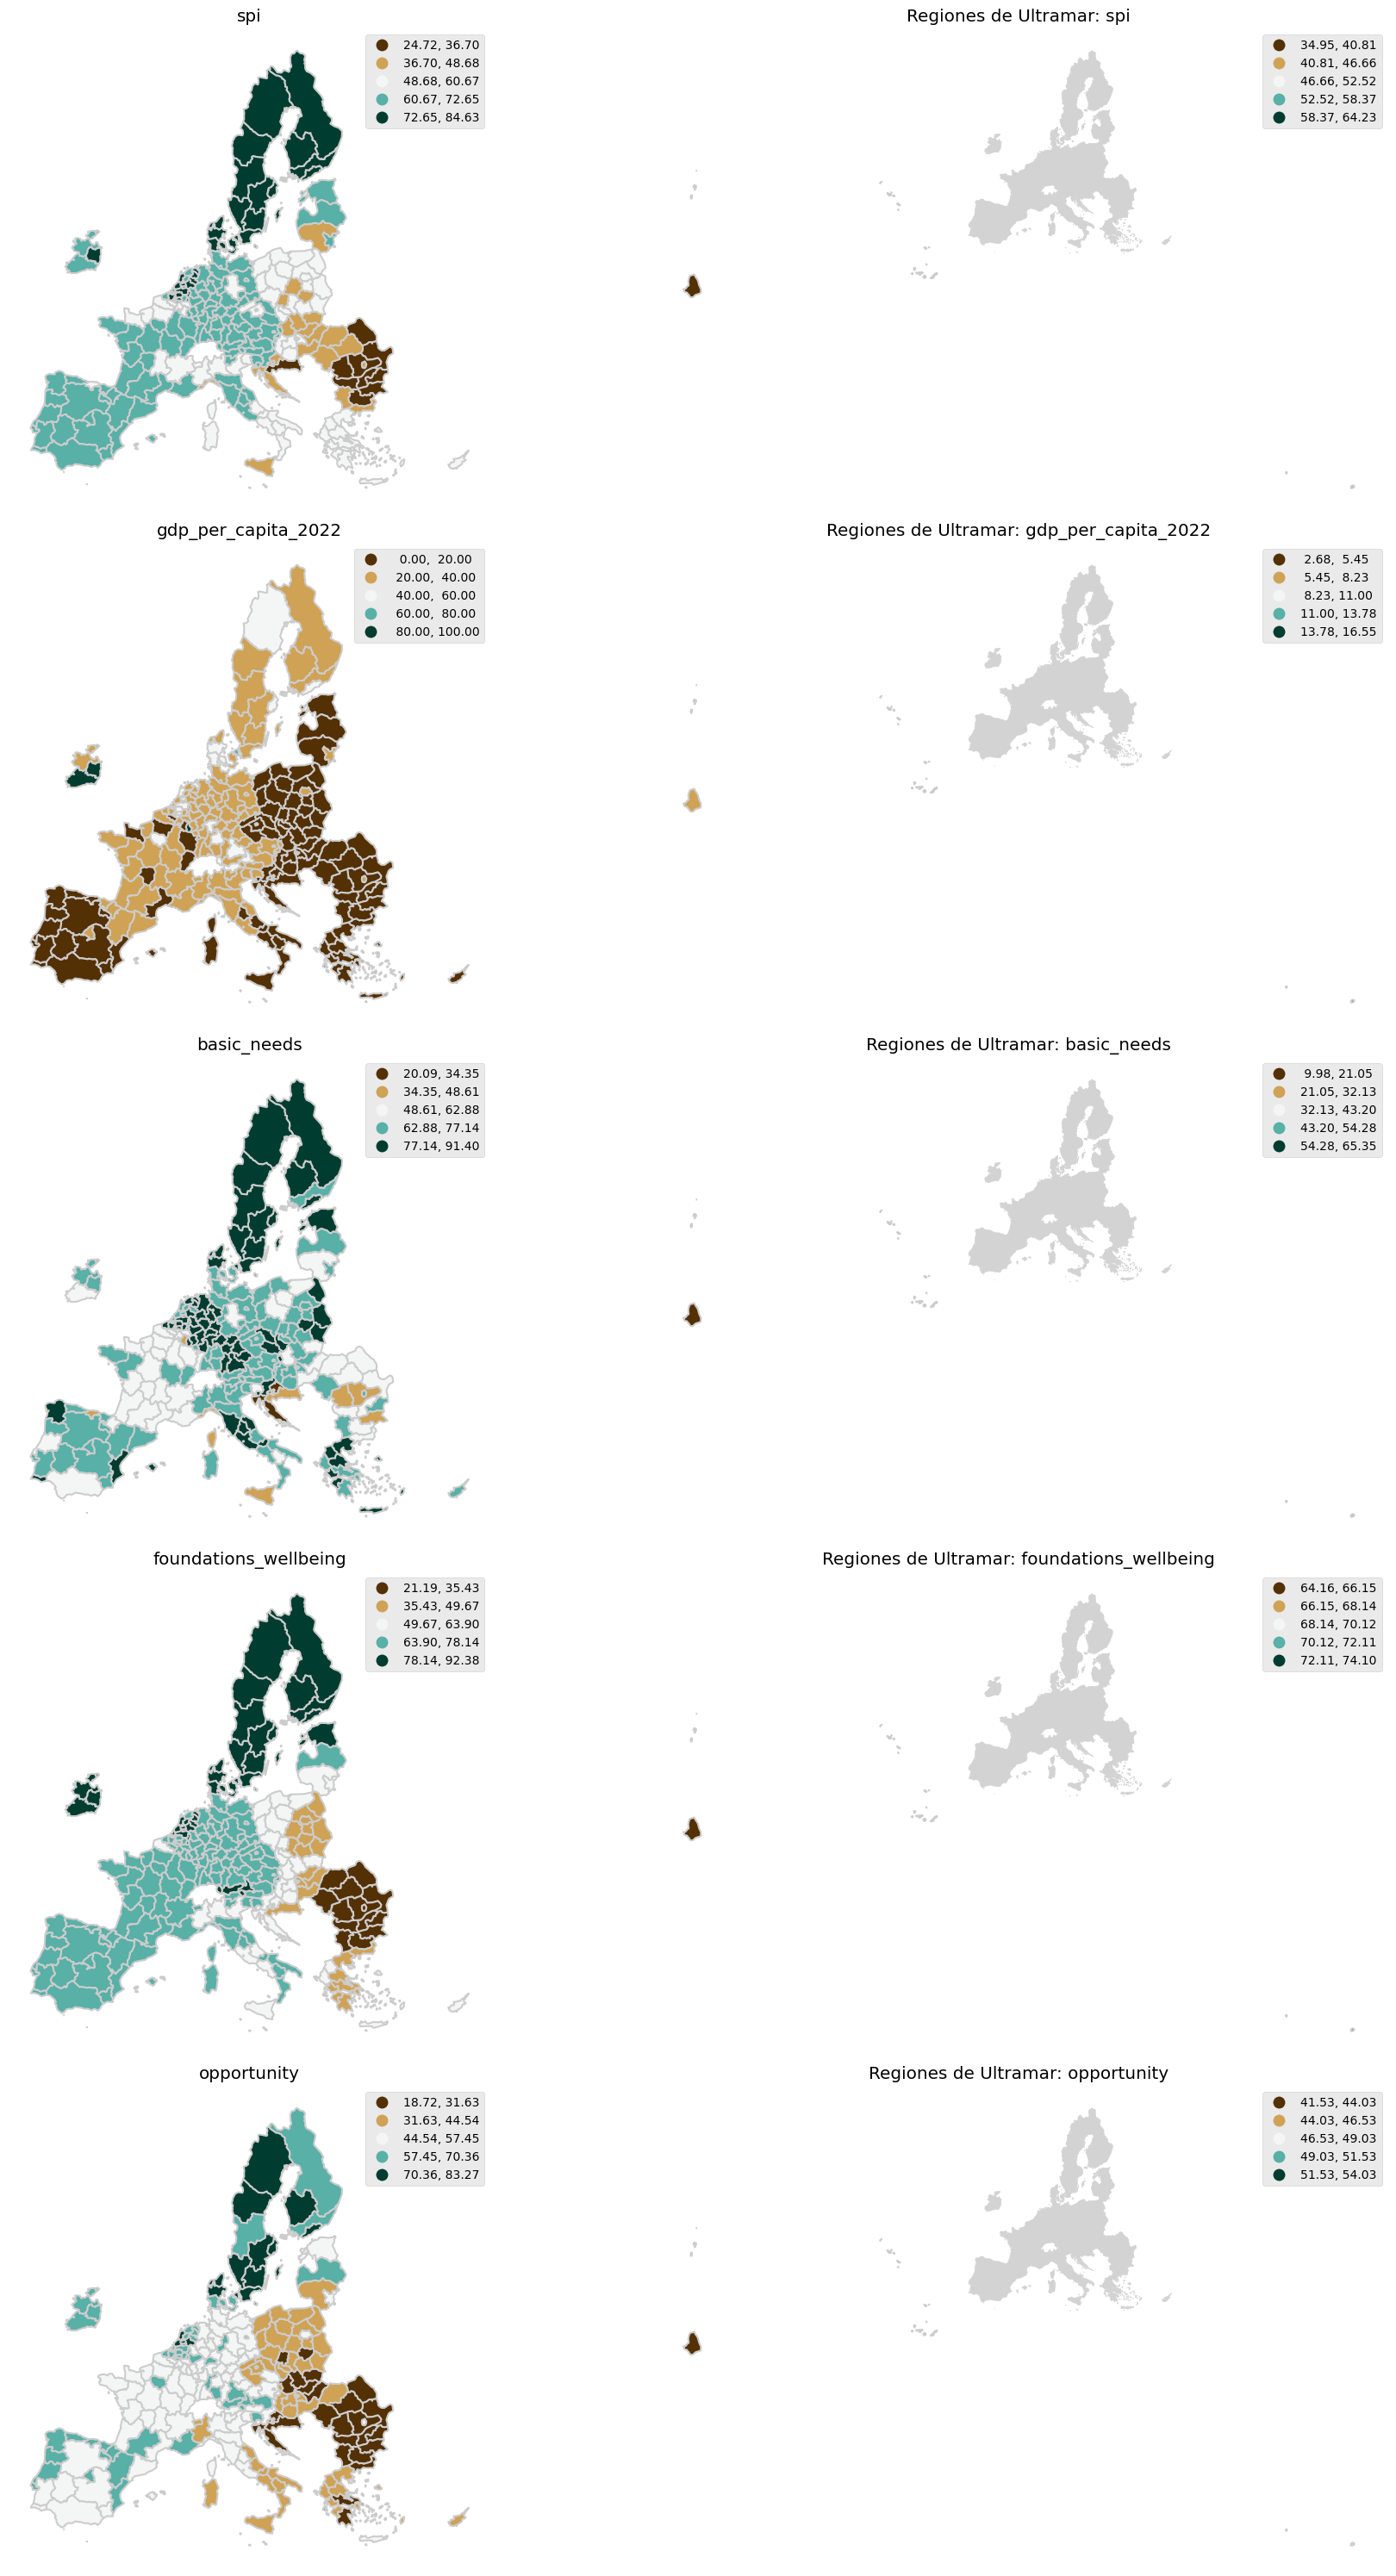

In [23]:
print('Figura 05.9')

fig, axes = plt.subplots(len(columns_of_interest), 2, figsize=(20, 30))

# Mapas
for i, col in enumerate(columns_of_interest):
    cmap = 'BrBG'
    scheme = 'equalinterval'
    plot_regions(axes[i, 0], axes[i, 1], filtered_gdf, filtered_gdf, overseas_gdf, col, f'{col}', f'Regiones de Ultramar: {col}', cmap=cmap, scheme=scheme)

plt.tight_layout()
plt.show()

**[Figura 05.10]** **std_mean**

Figura 05.10


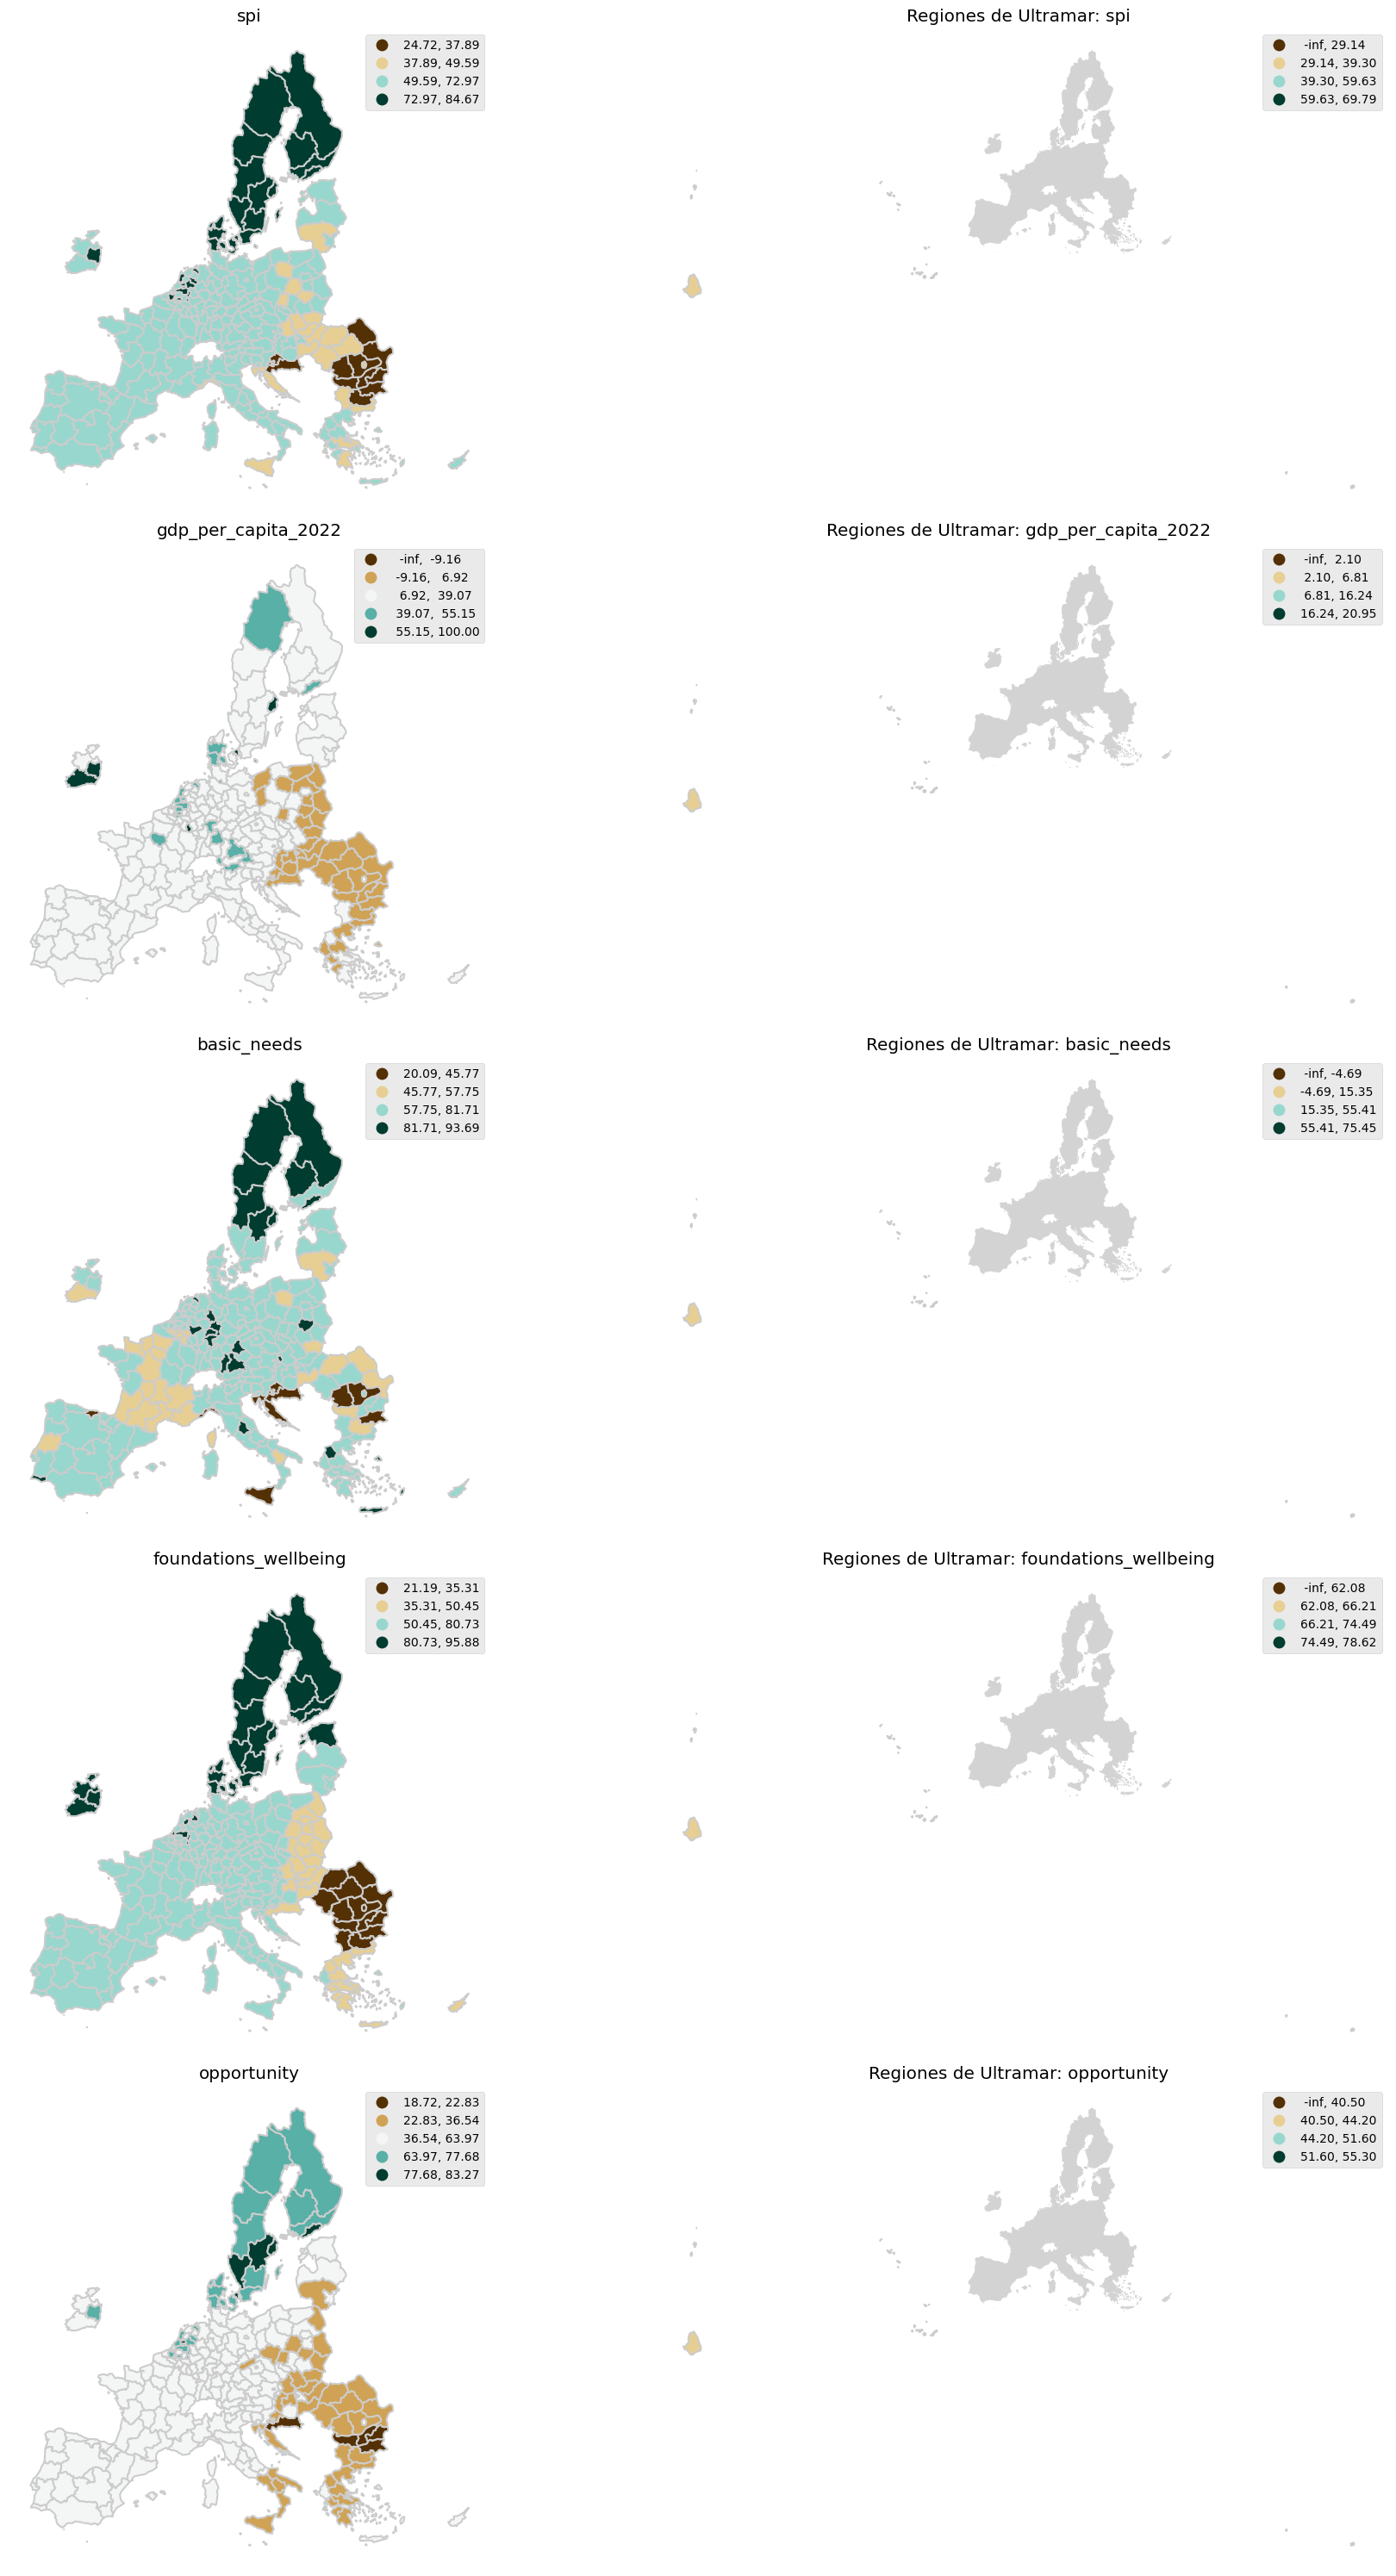

In [24]:
print('Figura 05.10')

fig, axes = plt.subplots(len(columns_of_interest), 2, figsize=(20, 30))

# Mapas
for i, col in enumerate(columns_of_interest):
    cmap = 'BrBG'
    scheme = 'std_mean'
    plot_regions(axes[i, 0], axes[i, 1], filtered_gdf, filtered_gdf, overseas_gdf, col, f'{col}', f'Regiones de Ultramar: {col}', cmap=cmap, scheme=scheme)

plt.tight_layout()
plt.show()

### Correlación SPI y PIB per cápita

**[Figura 05.11]**

Figura 05.11


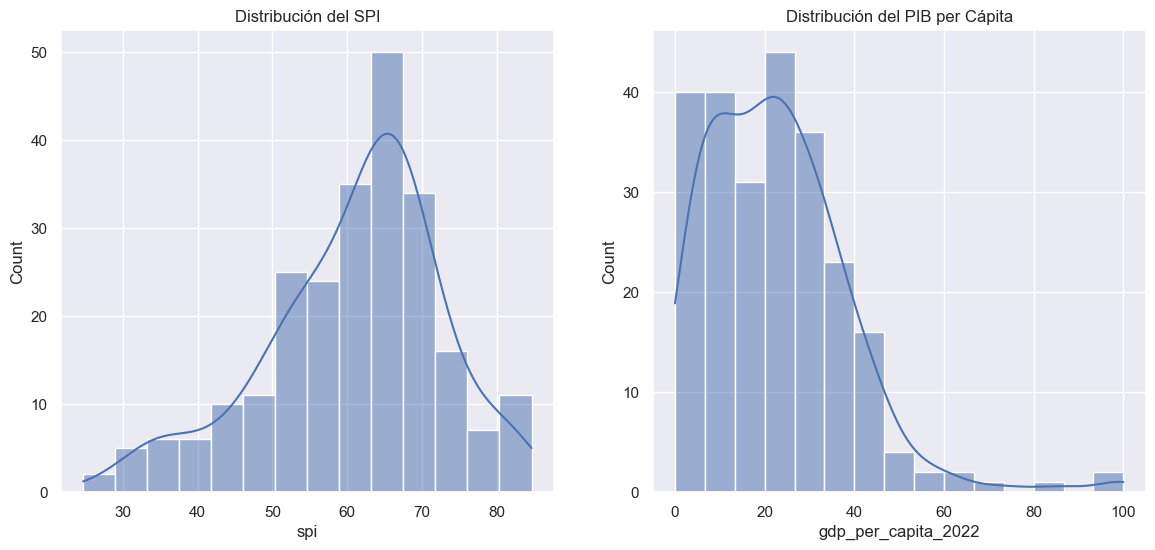

In [25]:
print('Figura 05.11')

sns.set_theme()
plt.figure(figsize=(14, 6))

# Histograma del SPI
plt.subplot(1, 2, 1)
sns.histplot(spi_df['spi'], kde=True)
plt.title('Distribución del SPI')

# Histograma del PIB per cápita
plt.subplot(1, 2, 2)
sns.histplot(spi_df['gdp_per_capita_2022'], kde=True)
plt.title('Distribución del PIB per Cápita')

plt.show()

In [26]:
correlation = spi_df[['spi', 'gdp_per_capita_2022']].corr().iloc[0, 1]
print(f'Correlación entre SPI y PIB per cápita: {correlation:.2f}')


Correlación entre SPI y PIB per cápita: 0.68


**[Figura 05.12]**

Figura 05.12


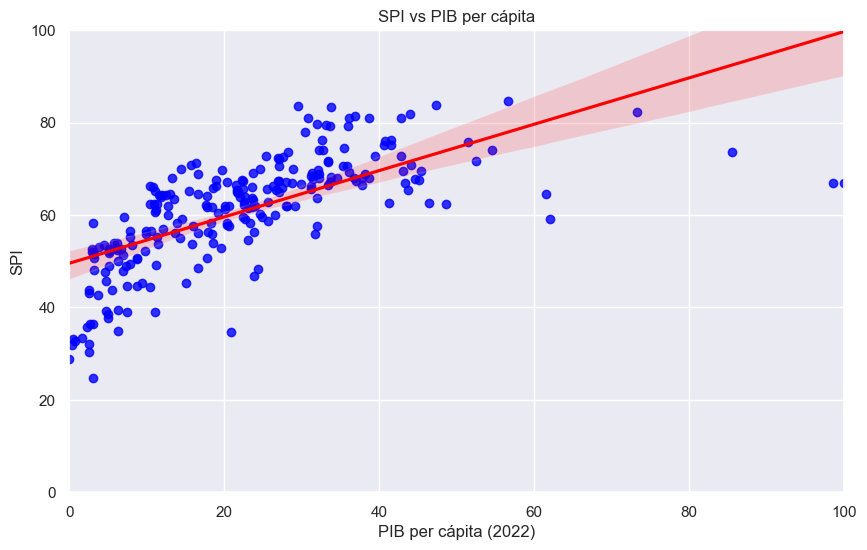

In [27]:
print('Figura 05.12')
plt.figure(figsize=(10, 6))

sns.regplot(x='gdp_per_capita_2022', y='spi', data=spi_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# Limitar el rango de los ejes
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.title('SPI vs PIB per cápita')
plt.xlabel('PIB per cápita (2022)')
plt.ylabel('SPI')

plt.show()

**[Figura 05.13]**

In [28]:
print('Figura 05.13')

# Crear la aplicación Dash
app = dash.Dash(__name__)

fig = px.scatter(spi_df, x='gdp_per_capita_2022', y='spi', color='region',                 
                 labels={'gdp_per_capita_2022': 'PIB per cápita', 'spi': 'SPI'},
                 width=1000, 
                 height=700)  

fig.update_layout(showlegend=False)

# Definir el layout de la aplicación
app.layout = html.Div(style={'width': '100%', 'height': '100vh', 'padding': '20px'}, children=[
    html.H1('SPI y PIB per cápita', style={'textAlign': 'center'}),
    dcc.Graph(figure=fig)
])

# Ejecutar
if __name__ == '__main__':
    app.run_server(debug=True)

Figura 05.13


# **Clustering**

## **Clustering jerárquico (SPI y PIB per capita)**

In [29]:
X = spi_df[['region','spi','gdp_per_capita_2022']]
X.set_index(['region'], inplace=True)


**[Figura 05.14]**

Figura 05.14

ward :	0.01s


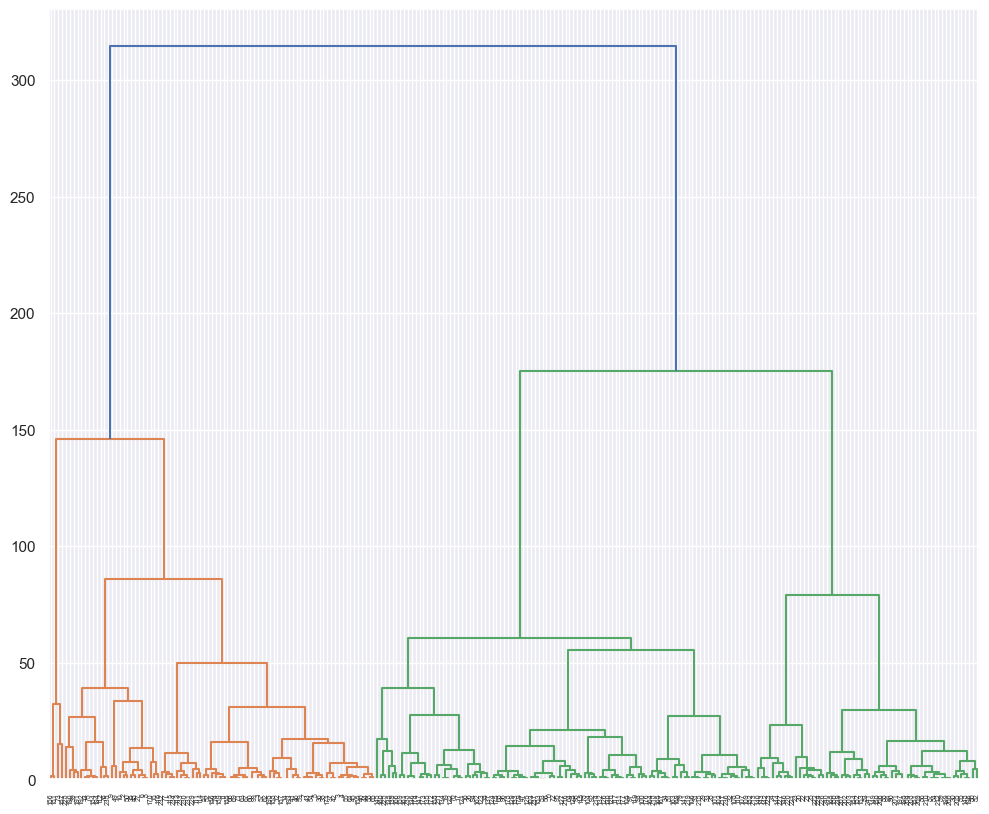

average :	0.00s


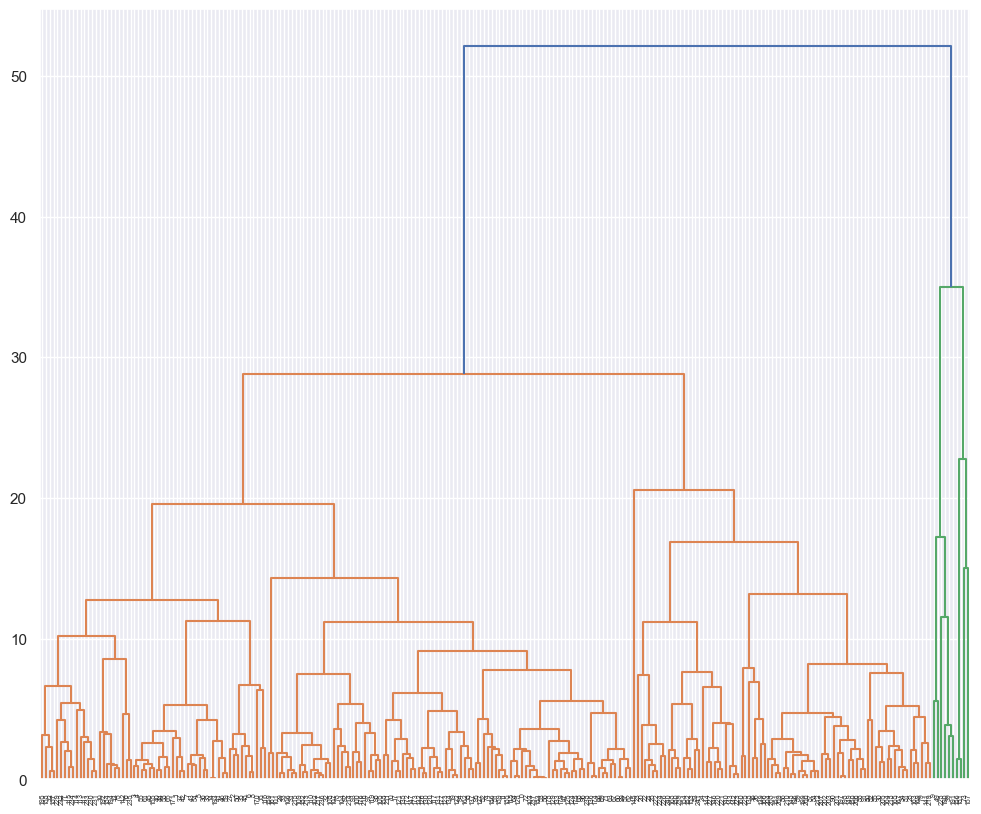

complete :	0.00s


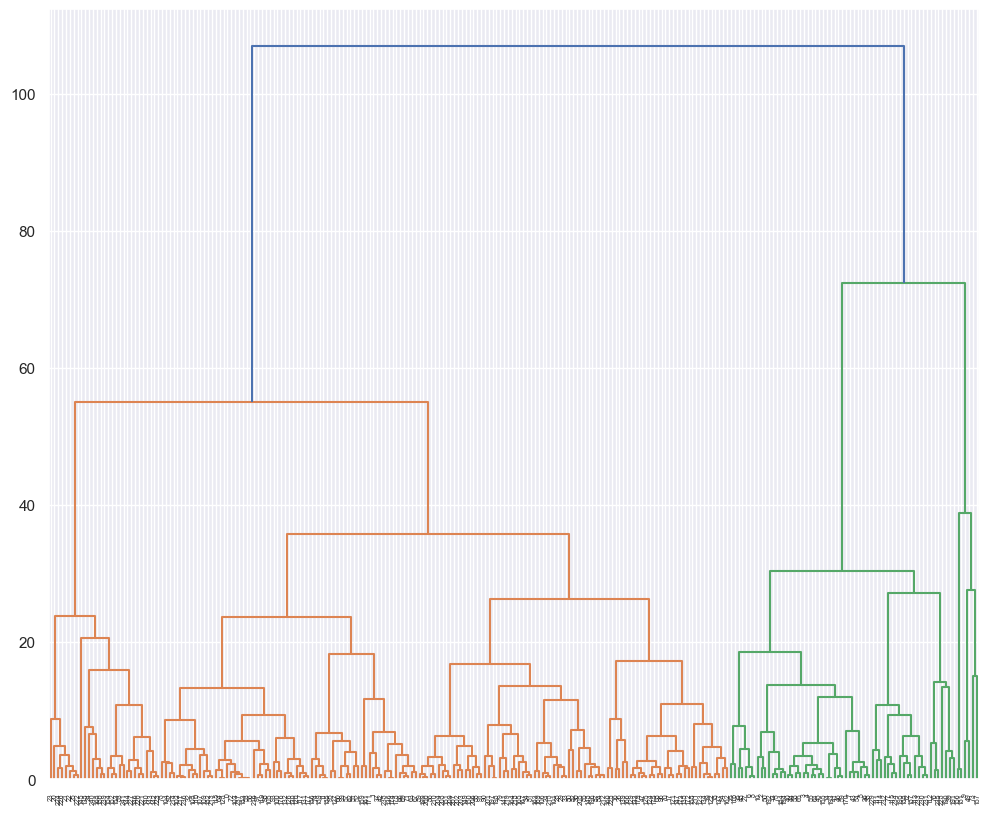

single :	0.00s


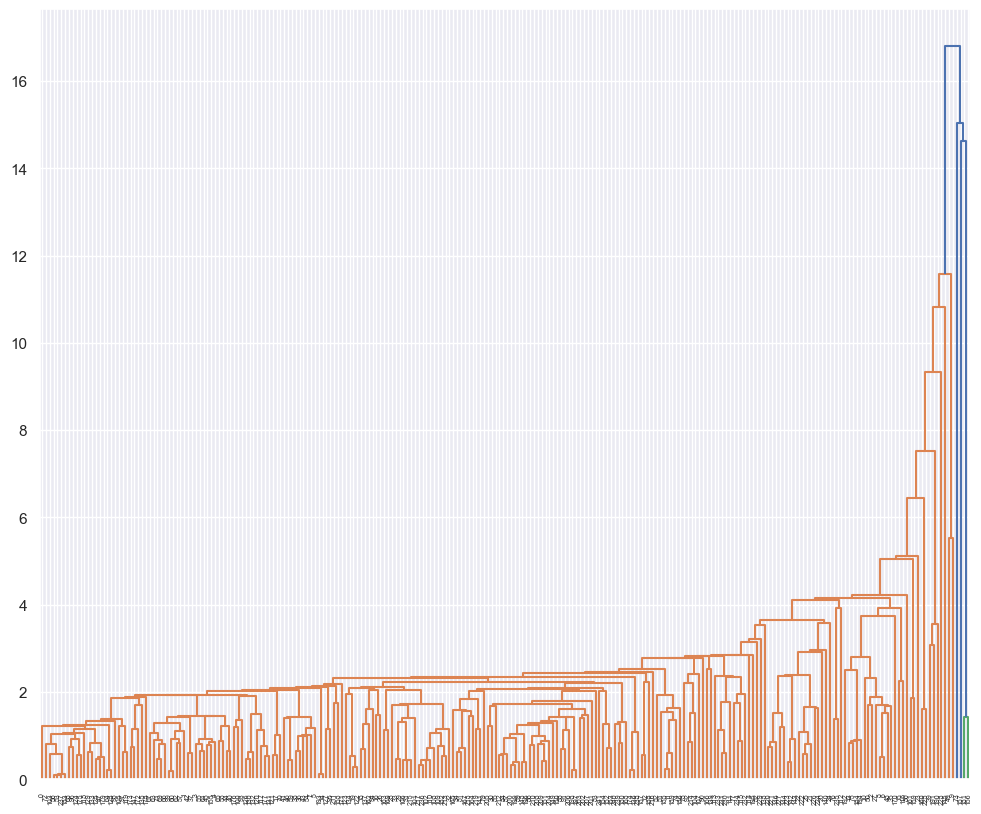

In [30]:
print('Figura 05.14')
print()

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(X) 
    print("%s :\t%.2fs" % (linkage, time() - t0)) 

    plt.clf()
    plot_dendogram(clustering) 


Método de mínima varianza de Ward. Probamos con varios grupos: entre 4 y 6

Extraeremos dos métricas de evaluación:

1. **Silueta**. El coeficiente de silueta se define para cada registro como $\frac{b-a}{max(a,b)}$ siendo **a** la distancia a su centroide y **b** la distancia al centroide del grupo más cercano y al que no pertenece dicho registro según la agrupación propuesta. Nos informa para cada registro de lo "bien" clasificado que se encuentra en su grupo actual o si tal vez estaría mejor perteneciendo al grupo más cercano. Valores por encima de 0.5 suelen ser aceptables, mientras que valores por debajo de 0.25 pueden indicar agrupaciones poco definidas.

2. **Indice de Calinski-Harabasz**. El criterio de la varianza. Compara la varianza entre grupos bss con la varianza intra wss a través de un cociente. Cuanto mayor sea el índice, mejor se considera el clustering. 


#### **3 grupos**

In [31]:
# defino el modelo:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 3
                     )
modelo_hclust_ward.fit(X=X) # Ajusto modelo a X

cluster_labels = modelo_hclust_ward.fit_predict(X) # Resultado: clasificacion de cada registro en su grupo


In [32]:
# Score global de silueta
silhouette_score(X, cluster_labels)

0.4154100211741045

In [33]:
# Siluteta para cada registro
silu=silhouette_samples(X, cluster_labels)


In [34]:
# Creo data con silueta y grupo
data=pd.concat([pd.Series(silu),pd.Series(cluster_labels)],axis=1)
data.columns=['Silueta','Cluster']

# Silueta media por grupo
data.groupby('Cluster').mean()

Silueta
Cluster          
0        0.302360
1        0.502352
2        0.461538

In [35]:
# Silueta mediana por grupo
data.groupby('Cluster').median()

Silueta
Cluster          
0        0.390397
1        0.541889
2        0.515798

In [36]:
# Desviación típica de la silueta por grupo
data.groupby('Cluster').std()

Silueta
Cluster          
0        0.227948
1        0.144014
2        0.195356

*Indice de Calinski-Harabasz clustering Ward*



In [37]:
metrics.calinski_harabasz_score(X, cluster_labels)

257.15665230989055

#### **4 grupos**

In [38]:
# defino el modelo:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 4
                     )
modelo_hclust_ward.fit(X=X)

cluster_labels = modelo_hclust_ward.fit_predict(X) # Resultado: clasificacion de cada registro en su grupo

In [39]:
# Score global de silueta
silhouette_score(X, cluster_labels)

0.4391416454992341

In [40]:
# Siluteta para cada registro
silu=silhouette_samples(X, cluster_labels)


In [41]:
# Creo data con silueta y grupo
data=pd.concat([pd.Series(silu),pd.Series(cluster_labels)],axis=1)
data.columns=['Silueta','Cluster']

# Silueta media por grupo
data.groupby('Cluster').mean()

Silueta
Cluster          
0        0.395653
1        0.502352
2        0.429652
3        0.638117

In [42]:
# Silueta mediana por grupo
data.groupby('Cluster').median()

Silueta
Cluster          
0        0.485825
1        0.541889
2        0.489984
3        0.720705

In [43]:
# Desviación típica de la silueta por grupo
data.groupby('Cluster').std()

Silueta
Cluster          
0        0.210099
1        0.144014
2        0.194825
3        0.191413

In [44]:
metrics.calinski_harabasz_score(X, cluster_labels)

307.35561041304874

#### **5 grupos**

In [45]:
# defino el modelo:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 5
                     )
modelo_hclust_ward.fit(X=X)

cluster_labels = modelo_hclust_ward.fit_predict(X) # Resultado: clasificacion de cada registro en su grupo

In [46]:
# Score global de silueta
silhouette_score(X, cluster_labels)

0.3970680588945516

In [47]:
# Siluteta para cada registro
silu=silhouette_samples(X, cluster_labels)

In [48]:
# Creo data con silueta y grupo
data=pd.concat([pd.Series(silu),pd.Series(cluster_labels)],axis=1)
data.columns=['Silueta','Cluster']

# Silueta media por grupo
data.groupby('Cluster').mean()

Silueta
Cluster          
0        0.502352
1        0.419555
2        0.343283
3        0.546035
4        0.291595

In [49]:
# Silueta mediana por grupo
data.groupby('Cluster').median()

Silueta
Cluster          
0        0.541889
1        0.443131
2        0.391890
3        0.659501
4        0.308407

In [50]:
# Desviación típica de la silueta por grupo
data.groupby('Cluster').std()

Silueta
Cluster          
0        0.144014
1        0.150564
2        0.208415
3        0.264790
4        0.138028

In [51]:
metrics.calinski_harabasz_score(X, cluster_labels)

297.35104571132996

#### **6 grupos**

In [52]:
# defino el modelo:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 6
                     )
modelo_hclust_ward.fit(X=X)

cluster_labels = modelo_hclust_ward.fit_predict(X) # Resultado: clasificacion de cada registro en su grupo

In [53]:
# Score global de silueta
silhouette_score(X, cluster_labels)

0.3822496458294285

In [54]:
# Siluteta para cada registro
silu=silhouette_samples(X, cluster_labels)

In [55]:
# Creo data con silueta y grupo
data=pd.concat([pd.Series(silu),pd.Series(cluster_labels)],axis=1)
data.columns=['Silueta','Cluster']

# Silueta media por grupo
data.groupby('Cluster').mean()

Silueta
Cluster          
0        0.262807
1        0.419555
2        0.563649
3        0.546035
4        0.291595
5        0.609524

In [56]:
# Silueta mediana por grupo
data.groupby('Cluster').median()

Silueta
Cluster          
0        0.346735
1        0.443131
2        0.673590
3        0.659501
4        0.308407
5        0.663045

In [57]:
# Desviación típica de la silueta por grupo
data.groupby('Cluster').std()

Silueta
Cluster          
0        0.244747
1        0.150564
2        0.202539
3        0.264790
4        0.138028
5        0.134387

In [58]:
metrics.calinski_harabasz_score(X, cluster_labels)

306.93067927573134

#### **Resultados Obtenidos**

* Para 3 Grupos:
  * Coeficiente de Silueta: 0.415
  * Índice de Calinski-Harabasz: 257.15

* Para 4 Grupos:
  * Coeficiente de Silueta: 0.439
  * Índice de Calinski-Harabasz: 307.35

* Para 5 Grupos:
  * Coeficiente de Silueta: 0.397
  * Índice de Calinski-Harabasz: 297.35

* Para 6 Grupos:
  * Coeficiente de Silueta: 0.382
  * Índice de Calinski-Harabasz: 306.93

**Número Óptimo de Clusters**:

- Basado en las métricas, 4 clusters parece ser la mejor opción 


In [59]:
# función de validación
from sklearn.utils import resample
def validate_clustering(X, num_clusters, n_iterations=10):
    silhouette_scores = []

    for _ in range(n_iterations):
        # Remuestrear datos
        X_resampled = resample(X, n_samples=int(0.8*len(X)))

        # Aplicar clustering
        clustering = AgglomerativeClustering(n_clusters=num_clusters)
        labels = clustering.fit_predict(X_resampled)

        # Calcular coeficiente de silueta
        score = silhouette_score(X_resampled, labels)
        silhouette_scores.append(score)

    return np.mean(silhouette_scores), np.std(silhouette_scores)



In [60]:
# Validar clustering para 4 clusters
mean_silhouette, std_silhouette = validate_clustering(X, num_clusters=4)
print(f'Media del coeficiente de silueta: {mean_silhouette}')
print(f'Desviación estándar del coeficiente de silueta: {std_silhouette}')

Media del coeficiente de silueta: 0.4428317823379449
Desviación estándar del coeficiente de silueta: 0.028831399966462026


In [61]:
# Validar clustering para 5 clusters
mean_silhouette, std_silhouette = validate_clustering(X, num_clusters=5)
print(f'Media del coeficiente de silueta: {mean_silhouette}')
print(f'Desviación estándar del coeficiente de silueta: {std_silhouette}')

Media del coeficiente de silueta: 0.42263547515061495
Desviación estándar del coeficiente de silueta: 0.03788233295339098


In [62]:
# Validar clustering para 3 clusters
mean_silhouette, std_silhouette = validate_clustering(X, num_clusters=3)
print(f'Media del coeficiente de silueta: {mean_silhouette}')
print(f'Desviación estándar del coeficiente de silueta: {std_silhouette}')

Media del coeficiente de silueta: 0.45227464622033275
Desviación estándar del coeficiente de silueta: 0.03893454997558896


## Clustering K-means (SPI y PIB per capita)

In [63]:
X = spi_df[['region','spi','gdp_per_capita_2022']]
X.set_index(['region'], inplace=True)


**[Figura 05.15]** **Evaluación del número de grupos óptimo en K-means**

Figura 05.15


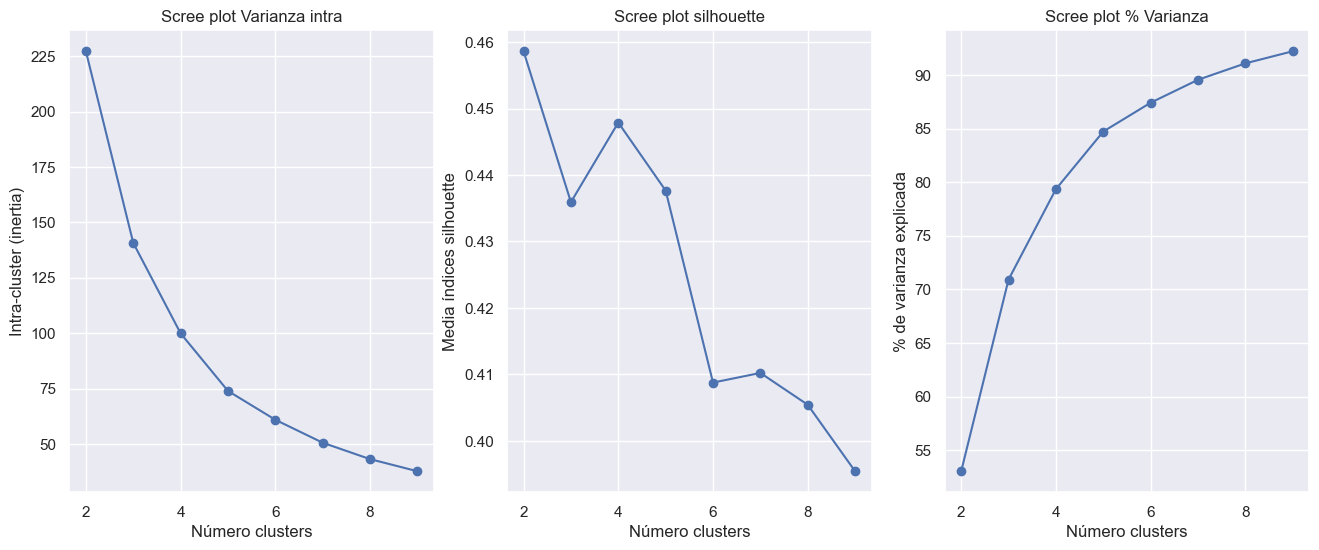

In [64]:
print('Figura 05.15')

scree_plot_kmeans(X,10)
plt.show()

**[Figura 05.16]**

Figura 05.16


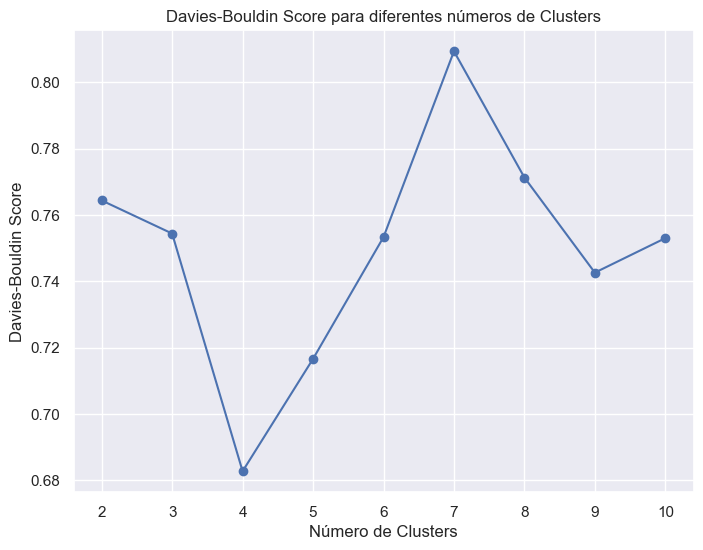

In [65]:
print('Figura 05.16')

from sklearn.metrics import davies_bouldin_score
k_values = range(2, 11) # Start from k=2
# Calcular el Davies-Bouldin Score para diferentes valores de k
db_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=123)
    labels = kmeans.fit_predict(X)
    db_score = davies_bouldin_score(X, labels)
    db_scores.append(db_score)

# Graficar el Davies-Bouldin Score
plt.figure(figsize=(8, 6))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score para diferentes números de Clusters')
plt.show()

Parece que el ideal es **4 grupos**. Probamos también con **5 grupos**

#### **4 grupos**

In [66]:
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
modelo_kmeans.fit(X=X)
print('Varianza intra: ' + str(round(modelo_kmeans.inertia_,2))) # varianza interna
print("==============================================")
print('Centroides')
print(modelo_kmeans.cluster_centers_.round(2))
print("==============================================")
print('Etiquetas')
modelo_kmeans.labels_[:5]

Varianza intra: 18198.36
Centroides
[[72.15 36.72]
 [61.85 19.26]
 [68.88 80.15]
 [45.2   5.97]]
Etiquetas


array([1, 0, 0, 0, 0])

In [67]:
# Crear un DataFrame para las etiquetas
df_clusters = pd.DataFrame(modelo_kmeans.labels_, columns=['cluster'], index=X.index)

# Calcular los intervalos máximos y mínimos por cada variable y cluster
intervalos = X.join(df_clusters).groupby('cluster').agg(['min', 'max'])

# Extraer y redondear los centroides
centroides = pd.DataFrame(modelo_kmeans.cluster_centers_, columns=X.columns).round(2)

In [68]:
intervalos

spi        gdp_per_capita_2022        
           min    max                 min     max
cluster                                          
0        62.48  84.63               25.40   56.62
1        46.79  71.32                7.07   31.93
2        59.02  82.28               61.54  100.00
3        24.72  58.23                0.00   20.93

In [69]:
centroides

spi  gdp_per_capita_2022
0  72.15                36.72
1  61.85                19.26
2  68.88                80.15
3  45.20                 5.97

In [70]:
y_predict = modelo_kmeans.predict(X=X)

silhouette_score(X, y_predict)

0.45856306150509074

In [71]:
metrics.calinski_harabasz_score(X, y_predict)

335.02427087861815

**[Figura 05.17]**

Figura 05.17


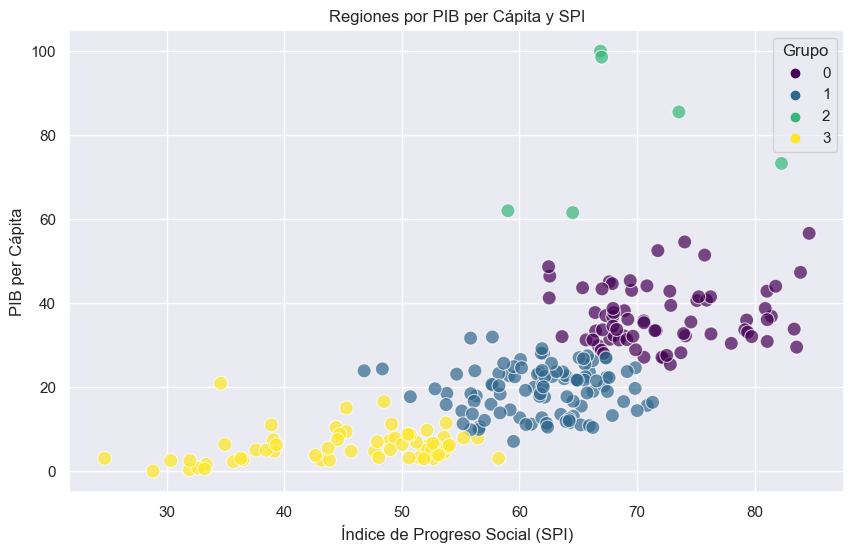

In [72]:
print('Figura 05.17')

X['cluster'] = modelo_kmeans.labels_

# Crear un gráfico de dispersión 
plt.figure(figsize=(10, 6))

sns.scatterplot(data=X, x='spi', y='gdp_per_capita_2022', hue='cluster', palette='viridis', s=100, alpha=0.7)

plt.title('Regiones por PIB per Cápita y SPI')
plt.xlabel('Índice de Progreso Social (SPI)')
plt.ylabel('PIB per Cápita')
plt.legend(title='Grupo')
plt.grid(True)
plt.show()

**[Figura 05.18]**

In [73]:
print('Figura 05.18')

fig = px.scatter(X, x='spi',y='gdp_per_capita_2022', color='cluster', hover_name=X.index)
fig.show()

Figura 05.18


Clasificación por 4 grupos:

- Grupo con niveles de PIB muy bajos y SPI oscila entre el mínimo y valores medios 

- Grupo con niveles bajos de PIB pero con un SPI medio y medio - alto 

- Grupo con niveles medios de PIB medios y un SPI de medio a muy alto (aquí está el máximo)

- Grupo con los niveles de PIB mas altos y SPI entre medio y alto. Este último grupo es muy pequeño, son las regiones que alargan la cola de la distribución del PIB muy a la derecha.



#### **5 grupos**

In [74]:
X.drop(columns='cluster', inplace=True)

In [75]:
modelo_kmeans = KMeans(n_clusters=5, n_init=25, random_state=123)
modelo_kmeans.fit(X=X)
print('Varianza intra: ' + str(round(modelo_kmeans.inertia_,2))) 
print("==============================================")
print('Centroides')
print(modelo_kmeans.cluster_centers_.round(2))
print("==============================================")
print('Etiquetas')
modelo_kmeans.labels_[:5]

Varianza intra: 14323.98
Centroides
[[37.7   5.04]
 [72.8  38.33]
 [55.3  10.38]
 [68.88 80.15]
 [64.33 23.23]]
Etiquetas


array([4, 4, 1, 1, 1])

In [76]:
df_clusters = pd.DataFrame(modelo_kmeans.labels_, columns=['cluster'], index=X.index)

# Calcular los intervalos máximos y mínimos por cada variable y cluster
intervalos = X.join(df_clusters).groupby('cluster').agg(['min', 'max'])

# Extraer y redondear los centroides
centroides = pd.DataFrame(modelo_kmeans.cluster_centers_, columns=X.columns).round(2)

In [77]:
intervalos

spi        gdp_per_capita_2022        
           min    max                 min     max
cluster                                          
0        24.72  45.68                0.00   20.93
1        62.48  84.63               28.18   56.62
2        45.28  66.24                2.95   24.33
3        59.02  82.28               61.54  100.00
4        54.66  72.83               13.24   32.02

In [78]:
centroides

spi  gdp_per_capita_2022
0  37.70                 5.04
1  72.80                38.33
2  55.30                10.38
3  68.88                80.15
4  64.33                23.23

In [79]:
y_predict = modelo_kmeans.predict(X=X)

silhouette_score(X, y_predict)

0.40756519126665136

In [80]:
metrics.calinski_harabasz_score(X, y_predict)

333.91648895847953

**[Figura 05.19]**

Figura 05.19


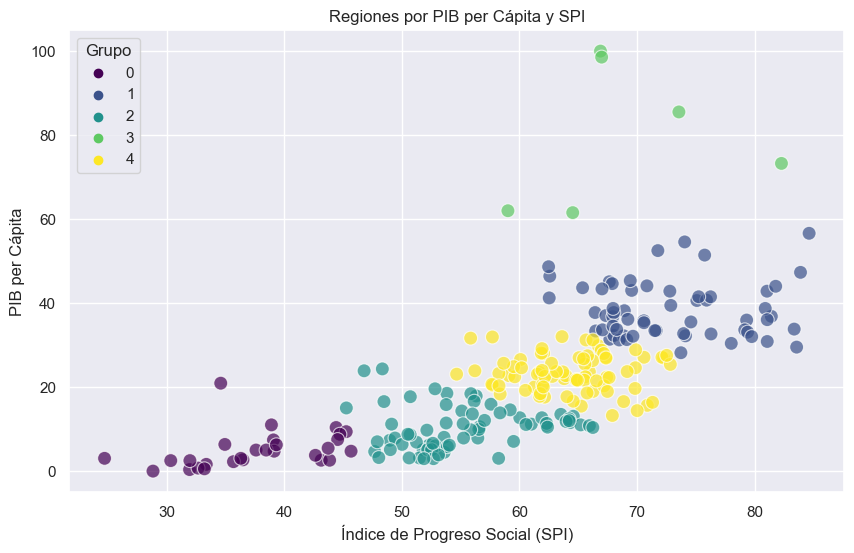

In [81]:
print('Figura 05.19')

X['cluster'] = modelo_kmeans.labels_

# Crear un gráfico de dispersión 
plt.figure(figsize=(10, 6))

sns.scatterplot(data=X, x='spi', y='gdp_per_capita_2022', hue='cluster', palette='viridis', s=100, alpha=0.7)

plt.title('Regiones por PIB per Cápita y SPI')
plt.xlabel('Índice de Progreso Social (SPI)')
plt.ylabel('PIB per Cápita')
plt.legend(title='Grupo')
plt.grid(True)
plt.show()

**[Figura 05.20]**

In [82]:
print('Figura 05.20')

fig = px.scatter(X, x='spi',y='gdp_per_capita_2022', color='cluster', hover_name=X.index)
fig.show()

Figura 05.20


Las metricas dan mejores resultados para 4 grupos aunque las diferencias son pequeñas.

La clasificación por 5 grupos añade un grupo en el lado del PIB y SPI mas bajos (más desfavorecidos), aunque no termina de diferenciarlo bien con el grupo conlindante. 

- Grupo con niveles de PIB de muy bajos SPI bajo a muy bajos

- Grupo con niveles de PIB bajos y SPI oscila entre el mínimo y valores medios 

- Grupo con niveles bajos de PIB pero con un SPI medio y medio - alto 

- Grupo con niveles medios de PIB medios y un SPI de medio a muy alto (aquí está el máximo)

- Grupo con los niveles de PIB mas altos y SPI entre medio y alto.

Nos quedamos con la clasificación por **5 grupos** por ser capaz de separar las regiones mas desfavorecidas del resto


#### **Renombrar grupos**

In [83]:
grupos = X.groupby('cluster').agg(['min', 'max'])
grupos[['spi', 'gdp_per_capita_2022']]

spi        gdp_per_capita_2022        
           min    max                 min     max
cluster                                          
0        24.72  45.68                0.00   20.93
1        62.48  84.63               28.18   56.62
2        45.28  66.24                2.95   24.33
3        59.02  82.28               61.54  100.00
4        54.66  72.83               13.24   32.02

In [84]:
centroides

spi  gdp_per_capita_2022
0  37.70                 5.04
1  72.80                38.33
2  55.30                10.38
3  68.88                80.15
4  64.33                23.23

Tenemos los siguientes 5 grupos:

* **Vulnerable**:

  * Centroides: [37.70 - 5.04]
  * Este grupo representa regiones con bajo desarrollo y bajo PIB per cápita. Destacan por una situación económica y de desarrollo desfavorable.
  * Existencia de un pequeño grupo de regiones solapada con el siguiente grupo.

* **Emerging**:

  * Centroides: [55.30 - 10.38]  
  
* **Stable**:

  * Centroides: [64.33 - 23.23]  


* **Prosperous**:

  * Centroides: [72.80, 38.33]

* **Affluent**:

  * Centroides: [68.88, 80.15]



#### **Agrego etiquetas de grupos a dataframe (5 grupos)**

In [85]:
X.reset_index(inplace=True)


In [86]:
# Definir los centroides de referencia para cada categoría
centroides_referencia = {
    "emerging": np.array([55.30, 10.38]),
    "affluent": np.array([68.88, 80.15]),
    "vulnerable": np.array([37.70, 5.04]),
    "prosperous": np.array([72.80, 38.33]),
    "stable": np.array([64.33, 23.23])
}

centroides_referencia

{'emerging': array([55.3 , 10.38]),
 'affluent': array([68.88, 80.15]),
 'vulnerable': array([37.7 ,  5.04]),
 'prosperous': array([72.8 , 38.33]),
 'stable': array([64.33, 23.23])}

In [87]:
# Crear un diccionario para los nombres de los clusters
nombres_cluster = {}

# Comparar los centroides obtenidos con los valores de referencia
for i, centroide in centroides.iterrows():
    distancias = {nombre: np.linalg.norm(centroide - valor) for nombre, valor in centroides_referencia.items()}
    nombre_cluster = min(distancias, key=distancias.get)  # Encontrar el nombre con la distancia mínima
    nombres_cluster[i] = nombre_cluster

In [88]:
# Reemplazar las etiquetas de los clústeres en tus datos
X['cluster_name'] = X['cluster'].map(nombres_cluster)


In [89]:
X.head()

region    spi  gdp_per_capita_2022  cluster cluster_name
0        Burgenland  65.95                23.61        4       stable
1  Niederösterreich  66.70                29.87        4       stable
2              Wien  69.54                43.02        1   prosperous
3           Kärnten  67.69                31.40        1   prosperous
4        Steiermark  68.03                32.29        1   prosperous

In [90]:
X.cluster.value_counts()

cluster
4    79
2    69
1    60
0    28
3     6
Name: count, dtype: int64

In [91]:
# Comparación de las etiquetas (tabla de contingencia)
tabla_frecuencia = pd.crosstab(X['cluster'], X['cluster_name'])
tabla_frecuencia

cluster_name  affluent  emerging  prosperous  stable  vulnerable
cluster                                                         
0                    0         0           0       0          28
1                    0         0          60       0           0
2                    0        69           0       0           0
3                    6         0           0       0           0
4                    0         0           0      79           0

In [92]:
spi_df = pd.merge(spi_df, X[['cluster_name', 'region']], on='region')


In [93]:
spi_df.rename(columns={'cluster_name': 'cluster_spi_gdp'}, inplace=True)
spi_df['cluster_spi_gdp'] = spi_df['cluster_spi_gdp'].astype('object')


In [94]:
spi_gdf = pd.merge(spi_gdf, X[['cluster_name', 'region']], on='region')
spi_gdf.rename(columns={'cluster_name': 'cluster_spi_gdp'}, inplace=True)
spi_gdf['cluster_spi_gdp'] = spi_gdf['cluster_spi_gdp'].astype('object')


**[Figura 05.21]** **Mapa Cluster SPI-GDP**

Figura 05.21


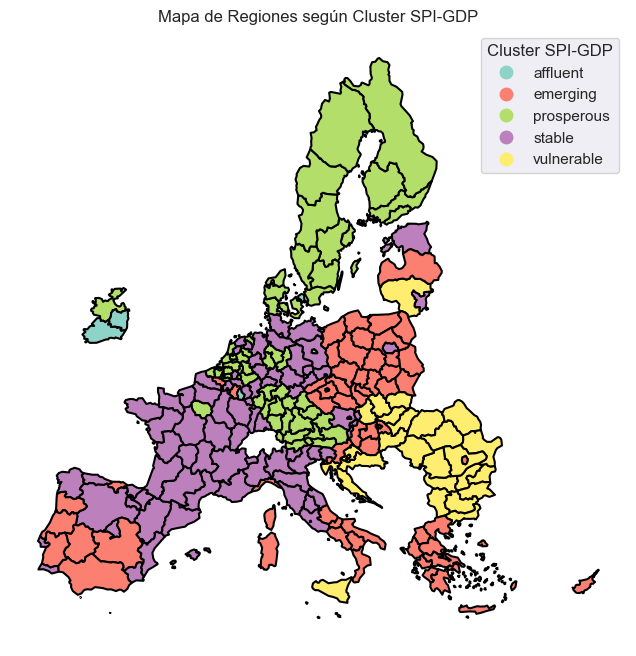

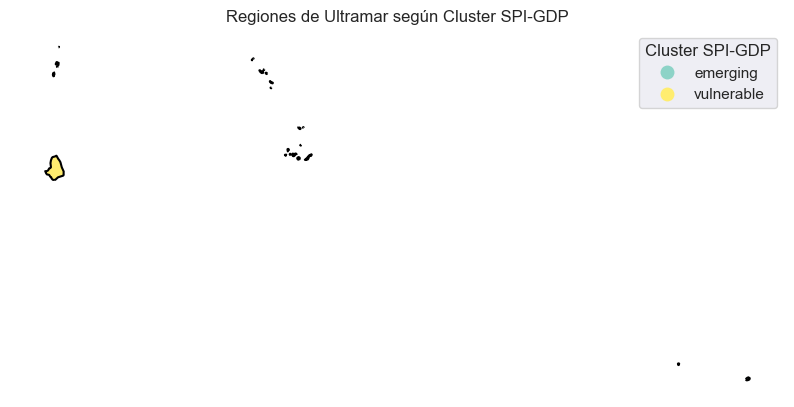

In [95]:
print('Figura 05.21')

overseas = ['Guyane', 'Guadeloupe', 'Martinique', 'La Réunion', 'Mayotte', "Região Autónoma dos Açores", 'Região Autónoma da Madeira', 'Canarias']
filtered_gdf = spi_gdf[~spi_gdf['region'].isin(overseas)]
overseas_gdf = spi_gdf[spi_gdf['region'].isin(overseas)]

# Configurar el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Dibujar el mapa usando la columna 'cluster_spi_gdp' para la coloración
filtered_gdf.plot(column='cluster_spi_gdp', ax=ax, legend=True,
         cmap='Set3',linewidth=1.5, edgecolor='black', legend_kwds={'title': 'Cluster SPI-GDP'})

# Personalizar el título y los ejes
ax.set_title('Mapa de Regiones según Cluster SPI-GDP')
ax.axis('off')

# Mostrar el mapa
plt.show()

#==============================================================================================

# Configurar el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Dibujar el mapa usando la columna 'cluster_spi_gdp' para la coloración
overseas_gdf.plot(column='cluster_spi_gdp', ax=ax, legend=True,
         cmap='Set3',linewidth=1.5, edgecolor='black', legend_kwds={'title': 'Cluster SPI-GDP'})

# Personalizar el título y los ejes
ax.set_title('Regiones de Ultramar según Cluster SPI-GDP')
ax.axis('off')

# Mostrar el mapa
plt.show()

**[Figura 05.22]**

Figura 05.22


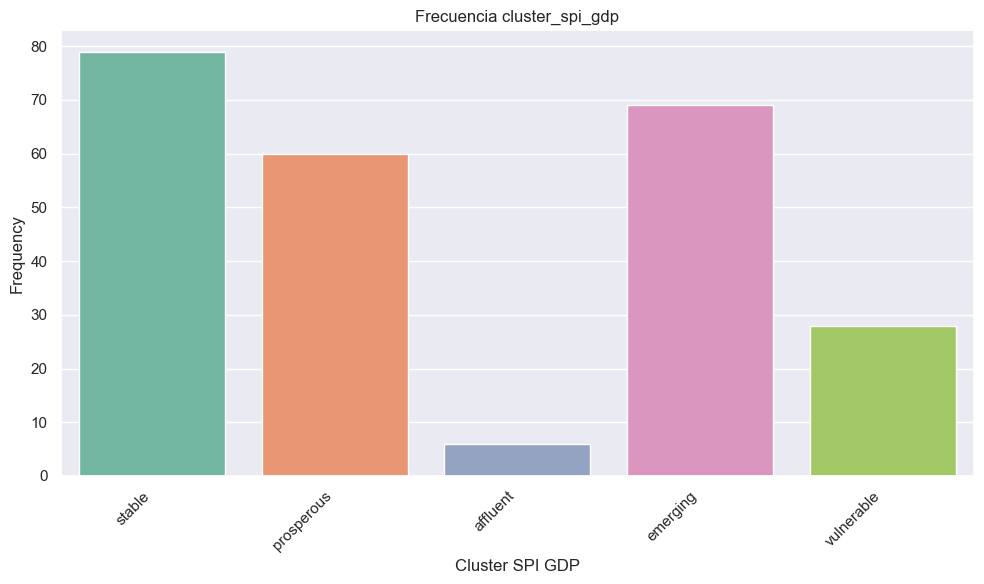

In [96]:
print('Figura 05.22')
plt.figure(figsize=(10, 6))

sns.countplot(data=spi_df, x='cluster_spi_gdp', palette='Set2')

plt.title('Frecuencia cluster_spi_gdp')
plt.xlabel('Cluster SPI GDP')
plt.ylabel('Frequency')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

**[Figura 05.23]**

In [97]:
print('Figura 05.23')

spi_df[['country', 'region','spi','gdp_per_capita_2022','cluster_spi_gdp']][spi_df['cluster_spi_gdp']=="vulnerable"]

Figura 05.23


country                               region    spi  gdp_per_capita_2022  \
20       BG                        Severozapaden  28.84                 0.00   
21       BG                   Severen tsentralen  31.95                 0.36   
22       BG                       Severoiztochen  33.37                 1.61   
23       BG                         Yugoiztochen  24.72                 3.04   
24       BG                          Yugozapaden  38.91                11.00   
25       BG                    Yuzhen tsentralen  32.67                 0.72   
83       EL          Anatoliki Makedonia, Thraki  45.68                 4.74   
140      FR                               Guyane  34.95                 6.35   
142      FR                              Mayotte  36.49                 2.68   
143      HR                    Panonska Hrvatska  35.68                 2.24   
144      HR                   Jadranska Hrvatska  39.08                 7.42   
145      HR                          Grad Zagreb  34.60                20.93   
146      HR                    Sjeverna Hrvatska  37.60                 5.01   
152      HU                   Észak-Magyarország  43.14                 2.59   
153      HU                         Észak-Alföld  43.86                 2.59   
154      HU                           Dél-Alföld  42.65                 3.76   
168      IT                              Sicilia  44.41                10.38   
180      LT  Vidurio ir vakarų Lietuvos regionas  45.27                 9.39   
220      RO                            Nord-Vest  39.14                 4.74   
221      RO                               Centru  38.46                 5.01   
222      RO                             Nord-Est  33.21                 0.54   
223      RO                              Sud-Est  36.31                 3.04   
224      RO                         Sud-Muntenia  30.35                 2.50   
226      RO                     Sud-Vest Oltenia  31.98                 2.50   
227      RO                                 Vest  39.33                 6.26   
239      SK                    Západné Slovensko  44.73                 8.77   
240      SK                    Stredné Slovensko  44.54                 7.51   
241      SK                   Východné Slovensko  43.73                 5.46   

    cluster_spi_gdp  
20       vulnerable  
21       vulnerable  
22       vulnerable  
23       vulnerable  
24       vulnerable  
25       vulnerable  
83       vulnerable  
140      vulnerable  
142      vulnerable  
143      vulnerable  
144      vulnerable  
145      vulnerable  
146      vulnerable  
152      vulnerable  
153      vulnerable  
154      vulnerable  
168      vulnerable  
180      vulnerable  
220      vulnerable  
221      vulnerable  
222      vulnerable  
223      vulnerable  
224      vulnerable  
226      vulnerable  
227      vulnerable  
239      vulnerable  
240      vulnerable  
241      vulnerable

**[Figura 05.24]**

In [98]:
print('Figura 05.24')

spi_df[['country', 'region','spi','gdp_per_capita_2022','cluster_spi_gdp']][spi_df['cluster_spi_gdp']=="affluent"]

Figura 05.24


country                                             region    spi  \
9        BE  Région de Bruxelles-Capitale/ Brussels Hoofdst...  59.02   
49       DE                                            Hamburg  64.53   
73       DK                                        Hovedstaden  82.28   
156      IE                                           Southern  66.89   
157      IE                                Eastern and Midland  73.56   
181      LU                                         Luxembourg  66.99   

     gdp_per_capita_2022 cluster_spi_gdp  
9                  61.99        affluent  
49                 61.54        affluent  
73                 73.26        affluent  
156               100.00        affluent  
157                85.51        affluent  
181                98.57        affluent

## Clustering K-means (Dimensiones)

In [99]:
X = spi_df[['region','basic_needs','foundations_wellbeing', 'opportunity']]
X.set_index(['region'], inplace=True)


**[Figura 05.25]**

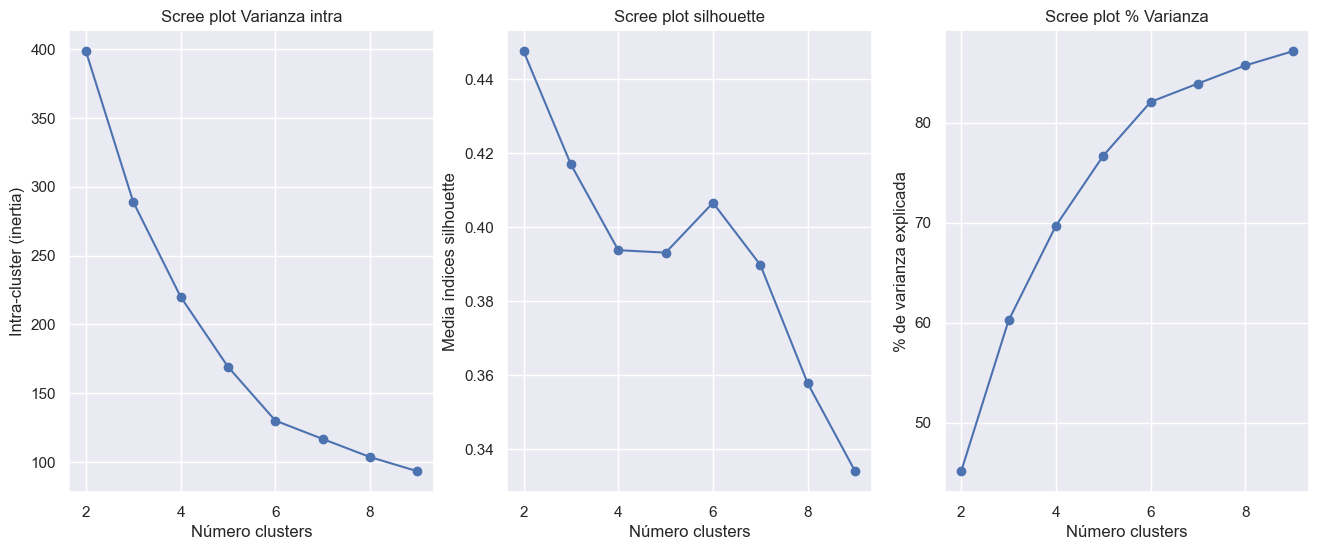

In [100]:
scree_plot_kmeans(X,10)
plt.show()

**[Figura 05.26]**

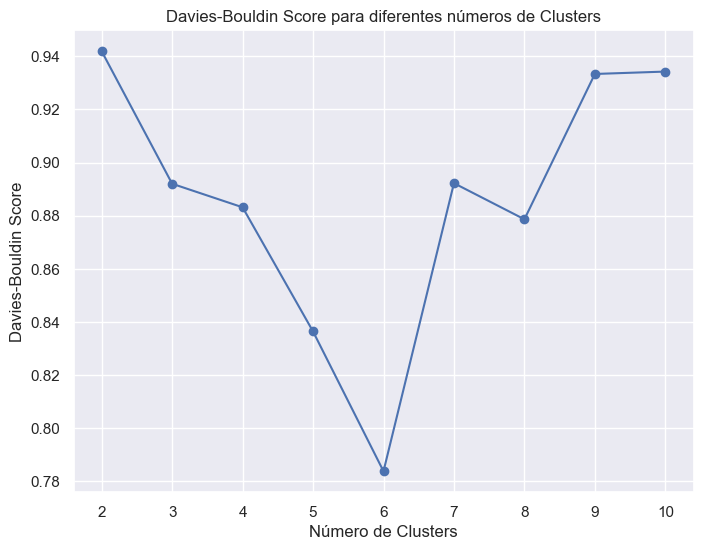

In [101]:
from sklearn.metrics import davies_bouldin_score
k_values = range(2, 11) # Start from k=2
# Calcular el Davies-Bouldin Score para diferentes valores de k
db_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=123)
    labels = kmeans.fit_predict(X)
    db_score = davies_bouldin_score(X, labels)
    db_scores.append(db_score)

# Graficar el Davies-Bouldin Score
plt.figure(figsize=(8, 6))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score para diferentes números de Clusters')
plt.show()

Parece que el número ideal son **6 grupos**

#### **5 grupos**

In [102]:
modelo_kmeans = KMeans(n_clusters=5, n_init=25, random_state=123)
modelo_kmeans.fit(X=X)
print('Varianza intra: ' + str(round(modelo_kmeans.inertia_,2))) # varianza interna
print("==============================================")
print('Centroides')
print(modelo_kmeans.cluster_centers_.round(2))
print("==============================================")
print('Etiquetas')
modelo_kmeans.labels_[:5]

Varianza intra: 32630.66
Centroides
[[75.02 71.47 54.3 ]
 [52.05 33.58 28.38]
 [73.17 52.88 37.2 ]
 [78.06 83.78 70.78]
 [49.8  70.96 51.54]]
Etiquetas


array([0, 0, 0, 0, 0])

In [103]:
df_clusters = pd.DataFrame(modelo_kmeans.labels_, columns=['cluster'], index=X.index)

# Calcular los intervalos máximos y mínimos por cada variable y cluster
intervalos = X.join(df_clusters).groupby('cluster').agg(['min', 'max'])

# Extraer y redondear los centroides
centroides = pd.DataFrame(modelo_kmeans.cluster_centers_, columns=X.columns).round(2)

In [104]:
intervalos

basic_needs        foundations_wellbeing        opportunity       
                min    max                   min    max         min    max
cluster                                                                   
0             61.70  87.34                 58.41  80.81       40.81  67.50
1             20.09  67.79                 21.19  51.65       18.72  45.95
2             57.46  87.16                 39.85  67.51       25.14  48.77
3             63.13  91.40                 74.23  92.38       60.77  83.27
4              9.98  61.61                 60.05  84.32       28.12  64.26

In [105]:
centroides

basic_needs  foundations_wellbeing  opportunity
0        75.02                  71.47        54.30
1        52.05                  33.58        28.38
2        73.17                  52.88        37.20
3        78.06                  83.78        70.78
4        49.80                  70.96        51.54

In [106]:
y_predict = modelo_kmeans.predict(X=X)

silhouette_score(X, y_predict)

0.39600995309343834

In [107]:
metrics.calinski_harabasz_score(X, y_predict)

200.4640466026326

**[Figura 05.27]**

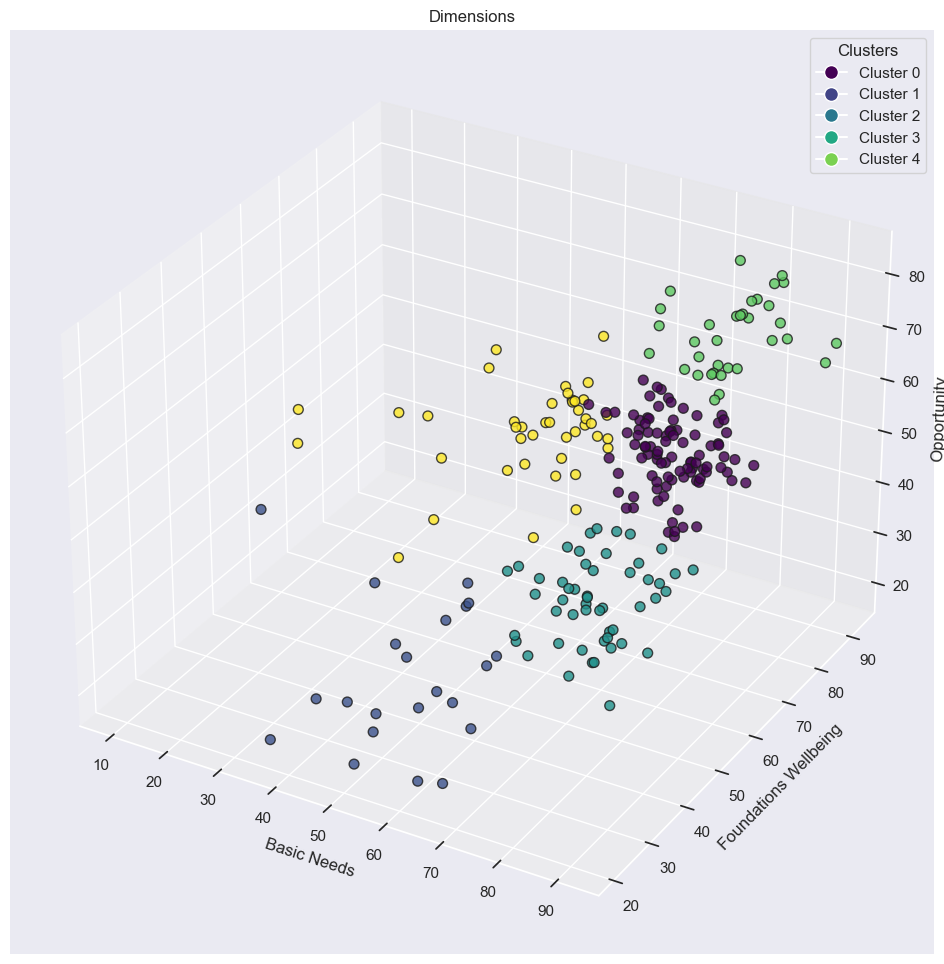

In [108]:
X['cluster'] = modelo_kmeans.labels_

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = X['basic_needs']
y = X['foundations_wellbeing']
z = X['opportunity']
c = X['cluster']  

# Graficar
scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=50, alpha=0.8, edgecolor='k')

ax.set_xlabel('Basic Needs')
ax.set_ylabel('Foundations Wellbeing')
ax.set_zlabel('Opportunity')
ax.set_title('Dimensions')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / X['cluster'].nunique()), markersize=10, label=f'Cluster {i}') for i in range(X['cluster'].nunique())]
ax.legend(handles=handles, title='Clusters')

plt.show()

#### **6 grupos**

In [109]:
X.drop(columns='cluster', inplace=True)

In [110]:
modelo_kmeans = KMeans(n_clusters=6, n_init=25, random_state=123)
modelo_kmeans.fit(X=X)
print('Varianza intra: ' + str(round(modelo_kmeans.inertia_,2))) # varianza interna
print("==============================================")
print('Centroides')
print(modelo_kmeans.cluster_centers_.round(2))
print("==============================================")
print('Etiquetas')
modelo_kmeans.labels_[:5]

Varianza intra: 25288.96
Centroides
[[75.68 71.58 54.22]
 [54.55 32.29 27.51]
 [73.17 52.88 37.2 ]
 [26.02 62.04 40.51]
 [78.48 84.01 71.26]
 [56.   71.99 54.26]]
Etiquetas


array([0, 0, 0, 0, 0])

In [111]:
df_clusters = pd.DataFrame(modelo_kmeans.labels_, columns=['cluster'], index=X.index)

# Calcular los intervalos máximos y mínimos por cada variable y cluster
intervalos = X.join(df_clusters).groupby('cluster').agg(['min', 'max'])

# Extraer y redondear los centroides
centroides = pd.DataFrame(modelo_kmeans.cluster_centers_, columns=X.columns).round(2)

In [112]:
intervalos

basic_needs        foundations_wellbeing        opportunity       
                min    max                   min    max         min    max
cluster                                                                   
0             66.18  87.34                 58.41  80.81       40.81  67.50
1             35.83  67.79                 21.19  51.65       18.72  45.95
2             57.46  87.16                 39.85  67.51       25.14  48.77
3              9.98  37.40                 41.58  73.72       28.12  47.87
4             67.46  91.40                 74.23  92.38       60.77  83.27
5             42.26  65.47                 62.52  84.32       35.03  64.26

In [113]:
centroides

basic_needs  foundations_wellbeing  opportunity
0        75.68                  71.58        54.22
1        54.55                  32.29        27.51
2        73.17                  52.88        37.20
3        26.02                  62.04        40.51
4        78.48                  84.01        71.26
5        56.00                  71.99        54.26

In [114]:
y_predict = modelo_kmeans.predict(X=X)

silhouette_score(X, y_predict)

0.4113759991419032

In [115]:
metrics.calinski_harabasz_score(X, y_predict)

219.758671010706

**[Figura 05.28]**

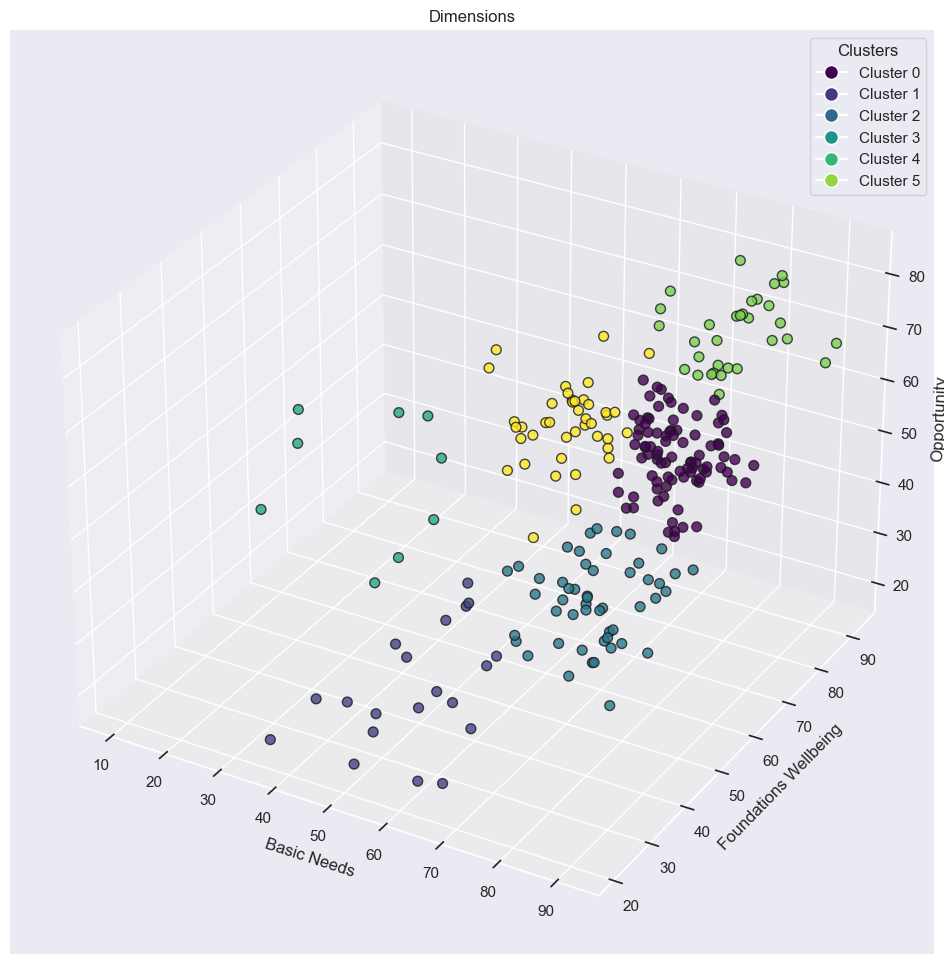

In [116]:
X['cluster'] = modelo_kmeans.labels_

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = X['basic_needs']
y = X['foundations_wellbeing']
z = X['opportunity']
c = X['cluster']  

# Graficar
scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=50, alpha=0.8, edgecolor='k')

ax.set_xlabel('Basic Needs')
ax.set_ylabel('Foundations Wellbeing')
ax.set_zlabel('Opportunity')
ax.set_title('Dimensions')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / X['cluster'].nunique()), markersize=10, label=f'Cluster {i}') for i in range(X['cluster'].nunique())]
ax.legend(handles=handles, title='Clusters')

plt.show()

Las metricas indican 6 grupos, aunque esta clasificación es confusa y poco interpretable

**[Figura 05.29]**

In [117]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Definir una paleta de colores para los clusters
colorscale = ['red', 'blue', 'green', 'purple', 'orange', 'yellow']  # Añadir más colores si es necesario

# Añadir las trazas para cada cluster
for i, cluster in enumerate(X['cluster'].unique()):
    cluster_data = X[X['cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['basic_needs'],
        y=cluster_data['foundations_wellbeing'],
        z=cluster_data['opportunity'],
        mode='markers',
        marker=dict(
            size=5,
            color=colorscale[i]  # Asignar color predefinido
        ),
        name=f'Cluster {cluster}'  # Etiqueta para la leyenda
    ))

# Actualizar el layout para ajustar el tamaño de la figura
fig.update_layout(
    scene=dict(
        xaxis_title='Basic Needs',
        yaxis_title='Foundations Wellbeing',
        zaxis_title='Opportunity'
    ),
    title='3D KMeans Clustering Visualization',
    legend_title='Clusters',
    width=1500,  # Ancho de la figura en píxeles
    height=800,  # Alto de la figura en píxeles
    margin=dict(r=0, l=0, b=0, t=0)  # Ajusta los márgenes del gráfico
)

# Mostrar el gráfico
fig.show()


## **Guardar Datasets**

In [118]:
spi_df.to_csv('05_spi_clusters_minmax.csv',
                     index = False)

spi_df.to_excel('05_spi_clusters_minmax.xlsx',
                     index = False)